In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt




import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp


plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R60D05LexA_jGCaMP7b_CsChrimsontdT_EL_hcKCR1')
sess_df = pd.read_csv(basedir / 'sessions.csv')
sess_df = sess_df.iloc[:-1]
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['condition'] for _, row in sess_df.iterrows()]
sess_df['mean offset'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['offset var.'] = [np.nan for _, row in sess_df.iterrows()]
sess_df['mean vec. len'] = [np.nan for _, row in sess_df.iterrows()]


figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/R60D05LexA_jGCaMP7b_CsChrimsontdT_EL_hcKCR1')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]

Index(['date', 'fly', 'sess', 'condition', 'scan_type', 'usable', 'notes'], dtype='object')


# Show opto response is similar across hcKCR1 flies and UAS control flies

In [3]:
def load_row(row):
    outdir = pathlib.PurePath( basedir / row['condition'] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)

In [4]:
opto_responses = {
    'remap_0deg': {'uas_control': [], 'hckcr1': []},
    'remap_180deg': {'uas_control': [], 'hckcr1': []},
    'combined': {'uas_control': [], 'hckcr1': []}
}

sess_df_remap0 = sess_df.loc[sess_df['scan_type']=='remap_0deg']
hckcr1 = sess_df_remap0.loc[sess_df_remap0['condition']=='hckcr1']
opto_responses['remap_0deg']['hckcr1'] = np.stack([nmp.remapping.get_opto_resp(load_row(row),zscore=True) for _, row in hckcr1.iterrows()])

uas_control = sess_df_remap0.loc[sess_df_remap0['condition']=='uas_control']
opto_responses['remap_0deg']['uas_control'] = np.stack([nmp.remapping.get_opto_resp(load_row(row),zscore=True) for _, row in uas_control.iterrows()]) 

sess_df_remap180 = sess_df.loc[sess_df['scan_type']=='remap_180deg']
hckcr1 = sess_df_remap180.loc[sess_df_remap180['condition']=='hckcr1']
opto_responses['remap_180deg']['hckcr1'] = np.stack([nmp.remapping.get_opto_resp(load_row(row),zscore=True) for _, row in hckcr1.iterrows()]) 

uas_control = sess_df_remap180.loc[sess_df_remap180['condition']=='uas_control']
opto_responses['remap_180deg']['uas_control'] = np.stack([nmp.remapping.get_opto_resp(load_row(row),zscore=True) for _, row in uas_control.iterrows()])   


opto_responses['combined']['uas_control'] = (opto_responses['remap_0deg']['uas_control'] + opto_responses['remap_180deg']['uas_control'])/2
opto_responses['combined']['hckcr1'] = (opto_responses['remap_0deg']['hckcr1'] + opto_responses['remap_180deg']['hckcr1'])/2



In [5]:
opto_responses['remap_0deg']['uas_control'].shape


(14, 16, 8, 5)

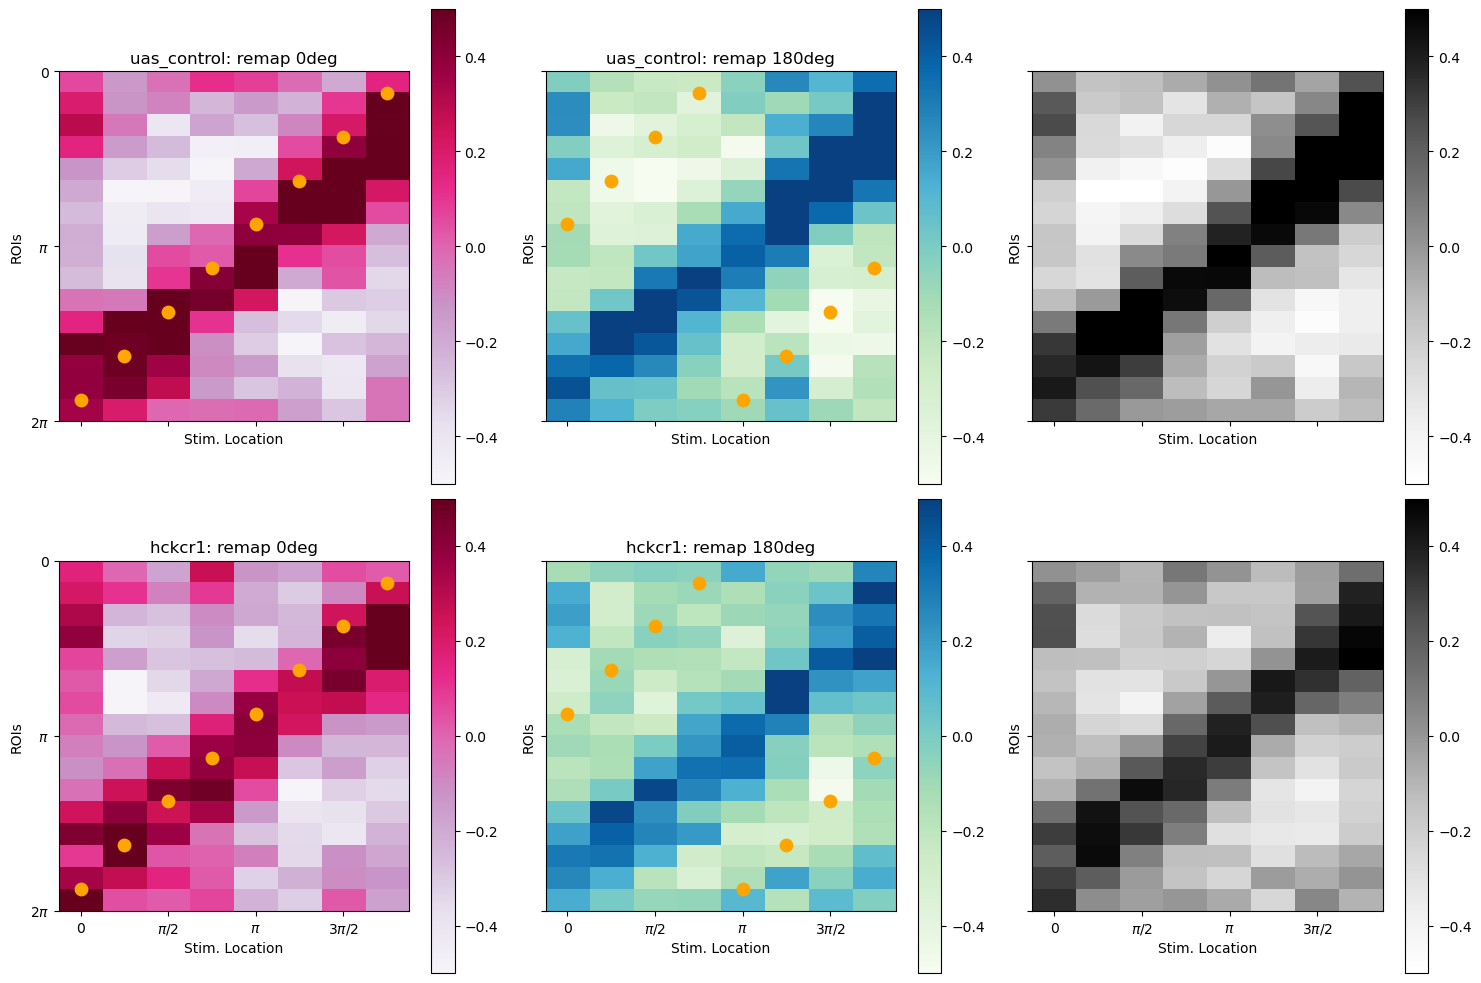

In [6]:
fig, ax = plt.subplots(2,3,figsize=[15,10],sharex=True,sharey=True)
h = ax[0,0].imshow(np.nanmean(opto_responses['remap_0deg']['uas_control'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[0,0])
h = ax[0,1].imshow(np.nanmean(opto_responses['remap_180deg']['uas_control'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[0,1])
h = ax[0,2].imshow(np.nanmean(opto_responses['combined']['uas_control'],axis=(0,3)), aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[0,2])


h = ax[1,0].imshow(np.nanmean(opto_responses['remap_0deg']['hckcr1'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='PuRd')
fig.colorbar(h, ax=ax[1,0])
h = ax[1,1].imshow(np.nanmean(opto_responses['remap_180deg']['hckcr1'],axis=(0,3)),aspect=.5, vmin=-.5, vmax=.5, cmap='GnBu')
fig.colorbar(h, ax=ax[1,1])
h = ax[1,2].imshow(np.nanmean(opto_responses['combined']['hckcr1'],axis=(0,3)), aspect=.5, vmin=-.5, vmax=.5, cmap='Greys')
fig.colorbar(h, ax=ax[1,2])



ax[0,0].set_title('uas_control: remap 0deg')
ax[0,1].set_title('uas_control: remap 180deg')
ax[1,0].set_title('hckcr1: remap 0deg')
ax[1,1].set_title('hckcr1: remap 180deg')

for r in range(2):
    x = np.arange(8)
    y = np.arange(0,2*np.pi,np.pi/4)[::-1]*8/np.pi+.5
    h = ax[r,0].scatter(x,y,color= 'orange',s=80)


    y = np.roll(y,4)
    ax[r,1].scatter(x,y,color='orange',s=80)
    

for a in ax.flatten():
    a.set_ylabel('ROIs')
    a.set_xlabel('Stim. Location')
    
    a.set_xticks([0,2,4,6], labels=[r'0',r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([-.5,7.5,15.5], labels=[r'0',r'$\pi$', r'2$\pi$'])
fig.tight_layout()

fig.savefig( figfolder / 'opto_resp_heatmaps.pdf')

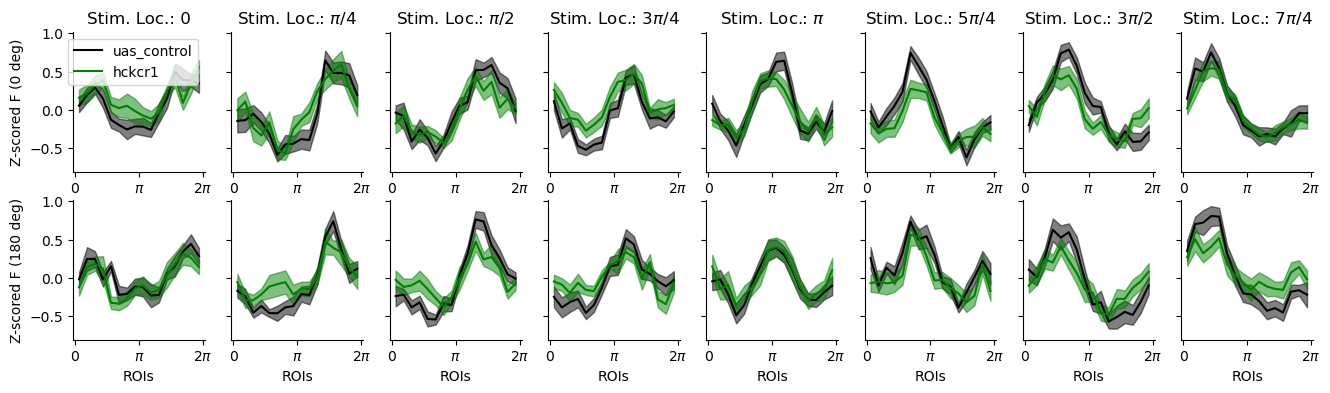

In [7]:
fig, ax = plt.subplots(2,8, figsize=[16,4], sharey=True)
x = np.arange(16)

mu, sem = opto_responses['remap_0deg']['uas_control'].mean(axis=(0,3)), sp.stats.sem(opto_responses['remap_0deg']['uas_control'].mean(axis=3),axis=0)
for i in range(8):
    ax[0,i].plot(x,mu[:,i],color='black', label='uas_control')
    ax[0,i].fill_between(x,mu[:,i]-sem[:,i],mu[:,i]+sem[:,i],alpha=.5, color='black')
    
mu, sem = opto_responses['remap_0deg']['hckcr1'].mean(axis=(0,3)), sp.stats.sem(opto_responses['remap_0deg']['hckcr1'].mean(axis=3),axis=0)
for i in range(8):
    ax[0,i].plot(x,mu[:,i],color='green', label='hckcr1')
    ax[0,i].fill_between(x,mu[:,i]-sem[:,i],mu[:,i]+sem[:,i],alpha=.5, color='green')
    
ax[0,0].legend()
mu, sem = opto_responses['remap_180deg']['uas_control'].mean(axis=(0,3)), sp.stats.sem(opto_responses['remap_180deg']['uas_control'].mean(axis=3),axis=0)
for i in range(8):
    ax[1,i].plot(x,mu[:,i],color='black')
    ax[1,i].fill_between(x,mu[:,i]-sem[:,i],mu[:,i]+sem[:,i],alpha=.5, color='black')
    
mu, sem = opto_responses['remap_180deg']['hckcr1'].mean(axis=(0,3)), sp.stats.sem(opto_responses['remap_180deg']['hckcr1'].mean(axis=3),axis=0)
for i in range(8):
    ax[1,i].plot(x,mu[:,i],color='green')
    ax[1,i].fill_between(x,mu[:,i]-sem[:,i],mu[:,i]+sem[:,i],alpha=.5, color='green')

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xticks([-.5,7.5,15.5], labels=[r'0',r'$\pi$', r'2$\pi$'])
    a.set_xlabel('ROIs')
    # a.set_ylabel('Z-scored F')
stim_locations = ['0', r'$\pi$/4', r'$\pi$/2', r'3$\pi$/4', r'$\pi$', r'5$\pi$/4',  r'3$\pi$/2', r'7$\pi$/4']
for i in range(8):
    ax[0,i].set_title(f'Stim. Loc.: {stim_locations[i]}')    

ax[0,0].set_ylabel('Z-scored F (0 deg)')
ax[1,0].set_ylabel('Z-scored F (180 deg)')

fig.savefig(figfolder / 'opto_resp_by_stim_loc.pdf')

Comparison of vector magnitude of population response: t=151.0,p=0.00388555598618073
Comparison of peak response: t=148.0,p=0.006111693541935177


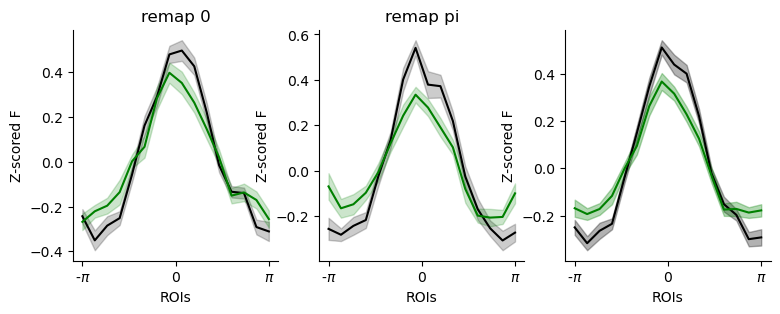

In [8]:

opto_resp_al = {}
for rk in ('remap_0deg', 'remap_180deg'):
    opto_resp_al[rk] = {}
    for ck in ('uas_control', 'hckcr1'):
        opto = np.copy(opto_responses[rk][ck])
        
        for i in range(8):
            opto[:,:,i,:] = np.roll(opto[:,:,i,:],2*i-8, axis=1)
            
        opto_resp_al[rk][ck] = opto
        

fig, ax = plt.subplots(1,3, figsize=[9,3])
x = np.linspace(-np.pi, np.pi, num=16)

uas_resp = opto_resp_al['remap_0deg']['uas_control'].mean(axis=(2,3))
hckcr1_resp = opto_resp_al['remap_0deg']['hckcr1'].mean(axis=(2,3))

mu, sem = uas_resp.mean(axis=0), sp.stats.sem(uas_resp, axis=0)
ax[0].plot(x, mu, color='black')
ax[0].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)

mu, sem = hckcr1_resp.mean(axis=0), sp.stats.sem(hckcr1_resp, axis=0)
ax[0].plot(x, mu, color='green')
ax[0].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

ax[0].set_title('remap 0')


uas_resp = opto_resp_al['remap_180deg']['uas_control'].mean(axis=(2,3))
hckcr1_resp = opto_resp_al['remap_180deg']['hckcr1'].mean(axis=(2,3))

x = np.linspace(-np.pi, np.pi, num=16)

mu, sem = uas_resp.mean(axis=0), sp.stats.sem(uas_resp, axis=0)
ax[1].plot(x, mu, color='black')
ax[1].fill_between(x, mu-sem, mu+sem, color='black', alpha=.2)

mu, sem = hckcr1_resp.mean(axis=0), sp.stats.sem(hckcr1_resp, axis=0)
ax[1].plot(x, mu, color='green')
ax[1].fill_between(x, mu-sem, mu+sem, color='green', alpha=.2)

ax[1].set_title('remap pi')



uas_resp = np.stack((opto_resp_al['remap_0deg']['uas_control'].mean(axis=(2,3)), opto_resp_al['remap_180deg']['uas_control'].mean(axis=(2,3)))).mean(axis=0)
hckcr1_resp = np.stack((opto_resp_al['remap_0deg']['hckcr1'].mean(axis=(2,3)), opto_resp_al['remap_180deg']['hckcr1'].mean(axis=(2,3)))).mean(axis=0)


mu, sem = uas_resp.mean(axis=0), sp.stats.sem(uas_resp, axis=0)
ax[2].plot(x,mu, color='black')
ax[2].fill_between(x, mu-sem, mu+sem, color='black', alpha=.3)

mu, sem = hckcr1_resp.mean(axis=0), sp.stats.sem(hckcr1_resp, axis=0)
ax[2].plot(x,mu, color='green')
ax[2].fill_between(x, mu-sem, mu+sem, color='green', alpha=.3)


t,p = sp.stats.mannwhitneyu(np.linalg.norm(uas_resp, axis=-1), np.linalg.norm(hckcr1_resp, axis=-1))
print(f'Comparison of vector magnitude of population response: t={t},p={p}')

t,p = sp.stats.mannwhitneyu(uas_resp[:,7:10].mean(axis=-1), hckcr1_resp[:,7:10].mean(axis=-1))
print(f'Comparison of peak response: t={t},p={p}')

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

    a.set_ylabel('Z-scored F')
    a.set_xlabel('ROIs')

    _ = a.set_xticks([-np.pi, 0, np.pi], labels = [r'-$\pi$', '0', r'$\pi$'])

fig.savefig( figfolder / "aligned_opto_resp.pdf")

# Summary plots

In [9]:
nonremap_sess_df = sess_df.loc[(sess_df['scan_type']=='baseline') | (sess_df['scan_type']=='post_0deg') | (sess_df['scan_type']=='post_180deg')]
flies = nonremap_sess_df['fly_id'].unique()

for index,row in nonremap_sess_df.iterrows():
    ts = nmp.session.GetTS(load_row(row))
    
    
    offset_c_mu = ts.offset_c.mean()
    
    sess_df.loc[index, 'mean offset'] = np.angle(offset_c_mu)
    sess_df.loc[index, 'mean vec. len'] = np.abs(offset_c_mu)
    sess_df.loc[index, 'offset var.'] = sp.stats.circvar(ts.offset)


In [10]:
sess_df.head()

date   fly              sess condition     scan_type  usable  notes  \
0  19_11_2024  fly1      baseline-000    hckcr1      baseline       1    NaN   
1  19_11_2024  fly1    remap_0deg-001    hckcr1    remap_0deg       1    NaN   
2  19_11_2024  fly1     post_0deg-002    hckcr1     post_0deg       1    NaN   
3  19_11_2024  fly1  remap_180deg-003    hckcr1  remap_180deg       1    NaN   
4  19_11_2024  fly1   post_180deg-004    hckcr1   post_180deg       1    NaN   

                   fly_id  mean offset  offset var.  mean vec. len  
0  19_11_2024_fly1_hckcr1    -0.621820     0.664985       0.335015  
1  19_11_2024_fly1_hckcr1          NaN          NaN            NaN  
2  19_11_2024_fly1_hckcr1    -1.062258     0.721103       0.278897  
3  19_11_2024_fly1_hckcr1          NaN          NaN            NaN  
4  19_11_2024_fly1_hckcr1    -0.853179     0.691963       0.308037

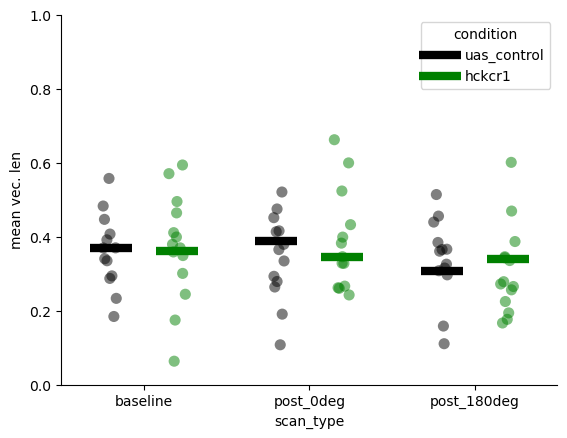

In [11]:
import seaborn as sns
fig, ax = plt.subplots()

colors = ['black', 'green']
tmp_sess_df = sess_df.loc[sess_df['scan_type'].isin(('baseline', 'post_0deg', 'post_180deg'))]

sns.stripplot(data=tmp_sess_df, x='scan_type', y='mean vec. len', ax=ax, alpha=.5,
            dodge=True, palette=colors, hue='condition', s=8, legend=False)
sns.pointplot(data=tmp_sess_df, x='scan_type', y='mean vec. len', ax=ax, 
              hue='condition', palette=colors, hue_order=['uas_control', 'hckcr1'],
              estimator=np.mean, errorbar=None, marker='_', markersize=30, 
              markeredgewidth=6, legend=True, dodge=.4, linestyle='none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0,1])
fig.savefig(figfolder / "remapping_vec_len_comparison.pdf")


In [12]:
fly_sum_stats = {
    'fly_id': [],
    'hckcr1': [],
}

for s in ('baseline', 'post_0deg', 'post_180deg'):
    fly_sum_stats[f'{s} mean offset'] = []
    fly_sum_stats[f'{s} vec. len'] = []
    fly_sum_stats[f'{s} offset var.'] = []
    
for fly in flies:
    fly_sum_stats['fly_id'].append(fly)
    fly_sum_stats['hckcr1'].append('hckcr1' in fly)
    for s in ('baseline', 'post_0deg', 'post_180deg'):
        fly_sum_stats[f'{s} mean offset'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean offset'].mean())
        fly_sum_stats[f'{s} vec. len'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['mean vec. len'].mean())
        fly_sum_stats[f'{s} offset var.'].append(sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']==s)]['offset var.'].mean())
        
fly_sum_stats = pd.DataFrame(fly_sum_stats)
fly_sum_stats.head()

fly_id  hckcr1  baseline mean offset  baseline vec. len  \
0  19_11_2024_fly1_hckcr1    True             -0.621820           0.335015   
1  19_11_2024_fly2_hckcr1    True             -2.684935           0.294091   
2  23_11_2024_fly1_hckcr1    True             -0.418937           0.369611   
3  25_11_2024_fly1_hckcr1    True             -0.249633           0.369947   
4  25_11_2024_fly2_hckcr1    True              2.010858           0.184244   

   baseline offset var.  post_0deg mean offset  post_0deg vec. len  \
0              0.664985              -1.062258            0.278897   
1              0.705909              -2.340208            0.292930   
2              0.630389              -0.415429            0.475118   
3              0.630053              -0.658163            0.413585   
4              0.815756               2.029395            0.365257   

   post_0deg offset var.  post_180deg mean offset  post_180deg vec. len  \
0               0.721103                -0.853179              0.308037   
1               0.707070                -2.915754              0.296866   
2               0.524882                -0.538001              0.315329   
3               0.586415                -0.446233              0.366244   
4               0.634743                 2.428506              0.325806   

   post_180deg offset var.  
0                 0.691963  
1                 0.703134  
2                 0.684671  
3                 0.633756  
4                 0.674194

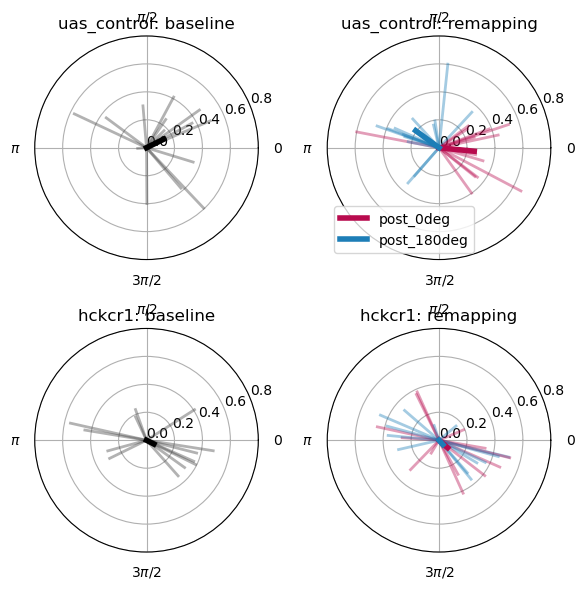

In [13]:
fig, ax = plt.subplots(2, 2, subplot_kw={'projection':'polar'}, figsize=[6,6])

uas_control = fly_sum_stats.loc[fly_sum_stats['hckcr1']==False]
for _, row in uas_control.iterrows():
    ax[0,0].plot(row['baseline mean offset']*np.ones([2,]), [0, row['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4, linewidth=2)
    
    ax[0,1].plot(row['post_0deg mean offset']*np.ones([2,]), [0, row['post_0deg vec. len']], color=plt.cm.PuRd(.8), alpha=.4, linewidth=2)
    ax[0,1].plot(row['post_180deg mean offset']*np.ones([2,]), [0, row['post_180deg vec. len']], color=plt.cm.GnBu(.8), alpha=.4, linewidth=2)

baseline_v = uas_control['baseline vec. len']*(np.cos(uas_control['baseline mean offset'])+1j*np.sin(uas_control['baseline mean offset']))
ax[0,0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=4)

post_0deg_v = uas_control['post_0deg vec. len']*(np.cos(uas_control['post_0deg mean offset'])+1j*np.sin(uas_control['post_0deg mean offset']))
ax[0,1].plot(np.angle(post_0deg_v.mean())*np.ones((2,)), np.absolute(post_0deg_v.mean())*np.array([0,1]), 
             color=plt.cm.PuRd(.8), linewidth=4, label='post_0deg')

post_180deg_v = uas_control['post_180deg vec. len']*(np.cos(uas_control['post_180deg mean offset'])+1j*np.sin(uas_control['post_180deg mean offset']))
ax[0,1].plot(np.angle(post_180deg_v.mean())*np.ones((2,)), np.absolute(post_180deg_v.mean())*np.array([0,1]), 
             color=plt.cm.GnBu(.8), linewidth=4, label='post_180deg')

ax[0,1].legend()
    
hckcr1 = fly_sum_stats.loc[fly_sum_stats['hckcr1']==True]
for _, row in hckcr1.iterrows():
    ax[1,0].plot(row['baseline mean offset']*np.ones([2,]), [0, row['baseline vec. len']], color=plt.cm.Greys(.8), alpha=.4, linewidth=2)
    
    ax[1,1].plot(row['post_0deg mean offset']*np.ones([2,]), [0, row['post_0deg vec. len']], color=plt.cm.PuRd(.8), alpha=.4, linewidth=2)
    ax[1,1].plot(row['post_180deg mean offset']*np.ones([2,]), [0, row['post_180deg vec. len']], color=plt.cm.GnBu(.8), alpha=.4, linewidth=2)

baseline_v = hckcr1['baseline vec. len']*(np.cos(hckcr1['baseline mean offset'])+1j*np.sin(hckcr1['baseline mean offset']))
ax[1,0].plot(np.angle(baseline_v.mean())*np.ones((2,)), np.absolute(baseline_v.mean())*np.array([0,1]), color='black', linewidth=4)

post_0deg_v = hckcr1['post_0deg vec. len']*(np.cos(hckcr1['post_0deg mean offset'])+1j*np.sin(hckcr1['post_0deg mean offset']))
ax[1,1].plot(np.angle(post_0deg_v.mean())*np.ones((2,)), np.absolute(post_0deg_v.mean())*np.array([0,1]), 
             color=plt.cm.PuRd(.8), linewidth=4)

post_180deg_v = hckcr1['post_180deg vec. len']*(np.cos(hckcr1['post_180deg mean offset'])+1j*np.sin(hckcr1['post_180deg mean offset']))
ax[1,1].plot(np.angle(post_180deg_v.mean())*np.ones((2,)), np.absolute(post_180deg_v.mean())*np.array([0,1]), color=plt.cm.GnBu(.8), linewidth=4)


for a in ax.flatten():
    a.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2], ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2'])
    a.set_yticks([0,.2,.4,.6,.8])
    a.set_ylim([0,.8])


ax[0,0].set_title('uas_control: baseline')
ax[0,1].set_title('uas_control: remapping')

ax[1,0].set_title('hckcr1: baseline')
ax[1,1].set_title('hckcr1: remapping')

fig.tight_layout()

fig.savefig(figfolder / "remapping_all_flies_polar.pdf")

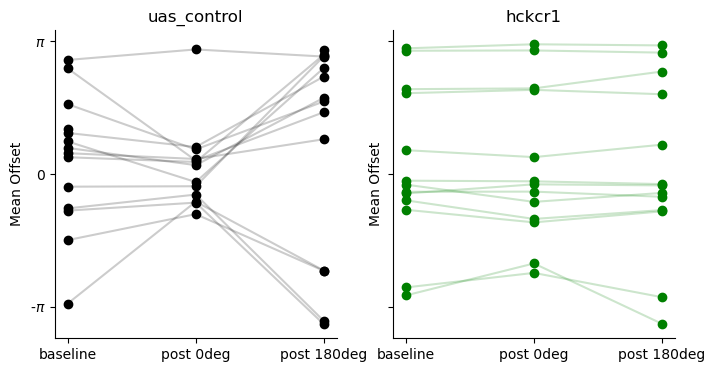

In [14]:
fig, ax = plt.subplots(1,2, figsize=[8,4], sharex=True, sharey=True)
nmp.remapping.plot_min_dist(uas_control, ax[0], color='black')
ax[0].set_title('uas_control')
nmp.remapping.plot_min_dist(hckcr1, ax[1], color='green')
ax[1].set_title('hckcr1')

for a in ax.flatten():
    a.set_xticks([0,1,2], ['baseline', 'post 0deg', 'post 180deg'])
    a.set_yticks([-np.pi,0,np.pi], [r'-$\pi$', '0', r'$\pi$'])
    a.set_ylabel('Mean Offset')
    
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

fig.savefig(figfolder / "remapping_all_flies.pdf")

test if UAS control error is less than chance: t=1.0, p=0.00048828125
test if hcKCR1 error is less than chance: t=34.0, p=0.454833984375
test for diff between groups: t = 12.0, p = 0.00022222837004574978


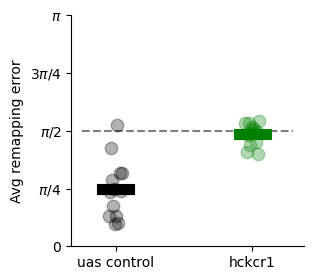

In [15]:
diff0 = np.abs(fly_sum_stats['post_0deg mean offset'] )
diff180 = np.abs(np.pi - fly_sum_stats['post_180deg mean offset'] )
diff180 = np.minimum(diff180, 2*np.pi-diff180)

fly_sum_stats['avg diff'] = (diff0+diff180)/2

fig, ax = plt.subplots(1,1, figsize=[3,3])
n_uas = fly_sum_stats.loc[fly_sum_stats['hckcr1']==False].shape[0]
uas_diff = fly_sum_stats.loc[fly_sum_stats['hckcr1']==False]['avg diff']
# print(uas_diff)
ax.scatter(np.linspace(0,.1,num=n_uas), uas_diff, color='black', alpha=.3, s=80)
ax.plot([-.05,.15],[np.mean(uas_diff),np.mean(uas_diff)], color='black', linewidth=8)

n_hckcr1 = fly_sum_stats.loc[fly_sum_stats['hckcr1']==True].shape[0]
hckcr1_diff = fly_sum_stats.loc[fly_sum_stats['hckcr1']==True]['avg diff']
ax.scatter(np.linspace(0,.1,num=n_hckcr1)+1, hckcr1_diff, color='green', alpha=.3, s=80)
ax.plot([.95,1.15],[np.mean(hckcr1_diff),np.mean(hckcr1_diff)], color='green', linewidth=8)

ax.plot([-.2,1.35], [np.pi/2, np.pi/2], 'k--', alpha=.5, zorder=-1)

ax.set_xticks([.05,1.05], labels=['uas control', 'hckcr1'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Avg remapping error')
_ = ax.set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4, np.pi], labels=[0, r"$\pi$/4", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])


# test whether uas_control is signifcantly less than pi/2

t, p = sp.stats.wilcoxon(uas_diff[~np.isnan(uas_diff)] - np.pi/2)
print(f"test if UAS control error is less than chance: t={t}, p={p}")


# test whether hckcr1 is significantly less than pi/2
t, p = sp.stats.wilcoxon(hckcr1_diff-np.pi/2)
print(f"test if hcKCR1 error is less than chance: t={t}, p={p}")

# test for diff between uas_control and hckckr1 
t, p = sp.stats.mannwhitneyu(uas_diff[~np.isnan(uas_diff)], hckcr1_diff)
print(f"test for diff between groups: t = {t}, p = {p}")


fig.savefig(figfolder / "remapping_error.pdf")

In [20]:
n_hckcr1 = fly_sum_stats.loc[fly_sum_stats['hckcr1']].shape[0]
n_ctrl = fly_sum_stats.loc[~fly_sum_stats['hckcr1']].shape[0]

print(f"HcKCR1: N = {n_hckcr1}")
print(f"control: N = {n_ctrl}")

HcKCR1: N = 13
control: N = 14


# Plot every session

(0, 2, 4) [0 1 2]
(0, 5, 3) [0 2 1]
(0, 2, 4) [0 1 2]
(0, 4, 2) [0 2 1]
(0, 2, 4) [0 1 2]
(1, 3, 6) [0 1 2]
(0, 2, 4) [0 1 2]


/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/remapping.py:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_polar, ax_polar = plt.subplots(subplot_kw={'projection':'polar'})


(0, 4, 2) [0 2 1]
(0, 2, 4) [0 1 2]
(0, 4, 2) [0 2 1]
(0, 2, 4) [0 1 2]
(0, 2, 4) [0 1 2]
(0, 4, 2) [0 2 1]
(0, 3, 5) [0 1 2]
(0, 8, 5) [0 2 1]
(0, 2, 4) [0 1 2]
(0, 2, 4) [0 1 2]
(0, 4, 2) [0 2 1]
(0, 4, 2) [0 2 1]
(0, 2, 4) [0 1 2]
(0, 2, 4) [0 1 2]
(0, 4, 2) [0 2 1]
(0, 2, 4) [0 1 2]
(0, 2, 6) [0 1 2]
(0, 5, 2) [0 2 1]
(1, 3, 5) [0 1 2]


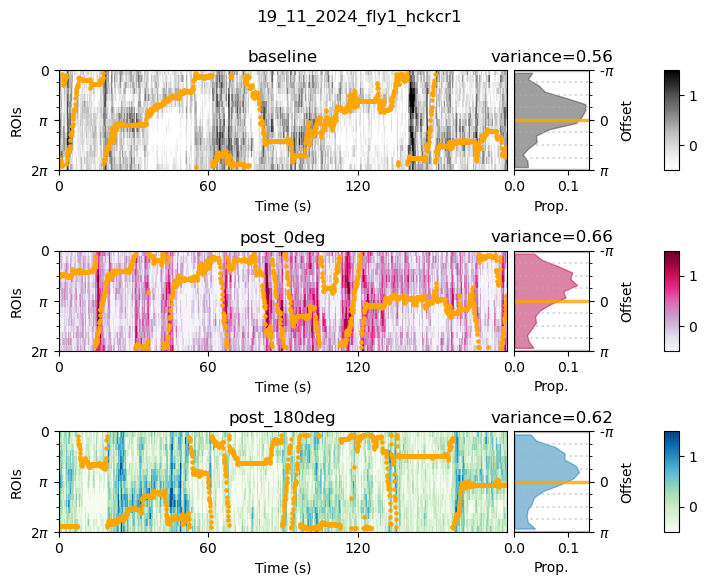

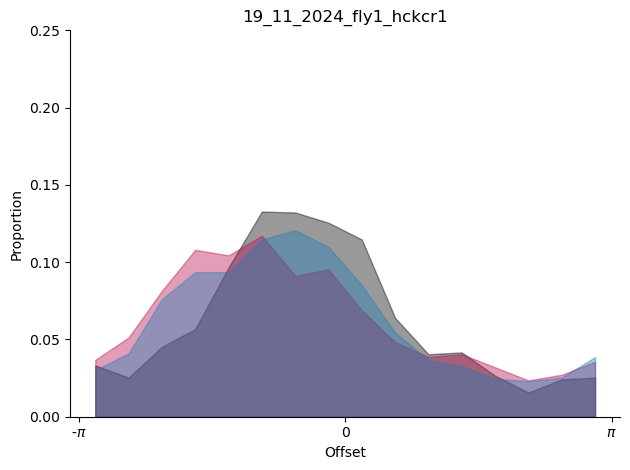

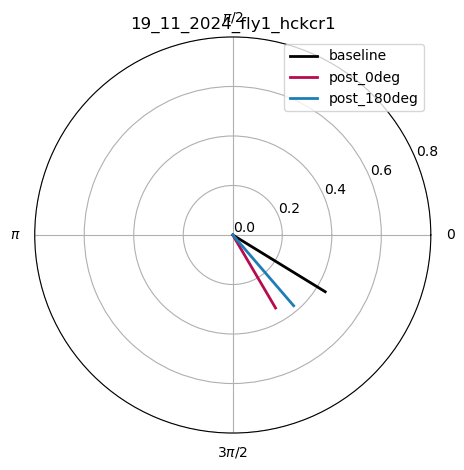

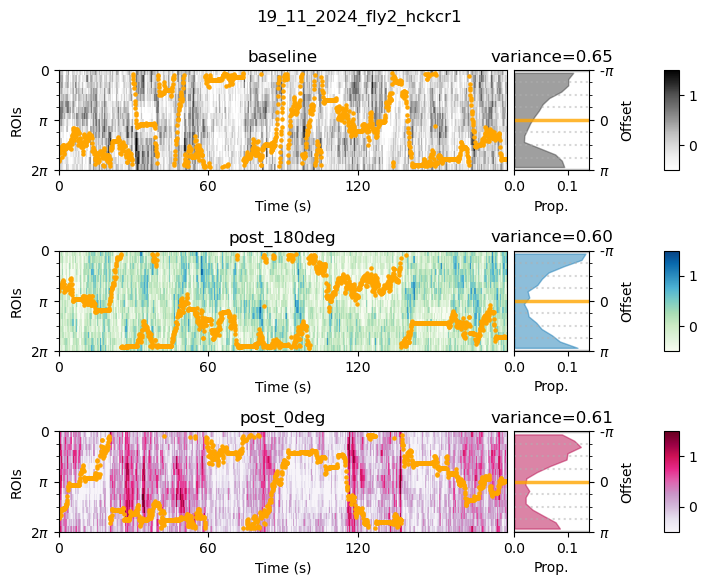

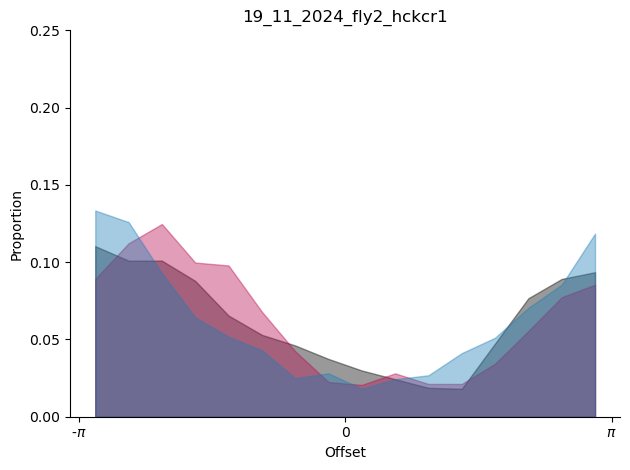

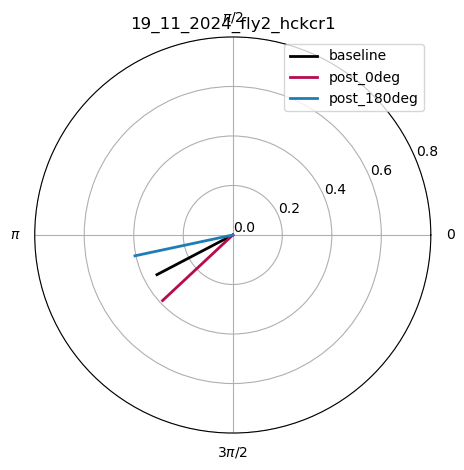

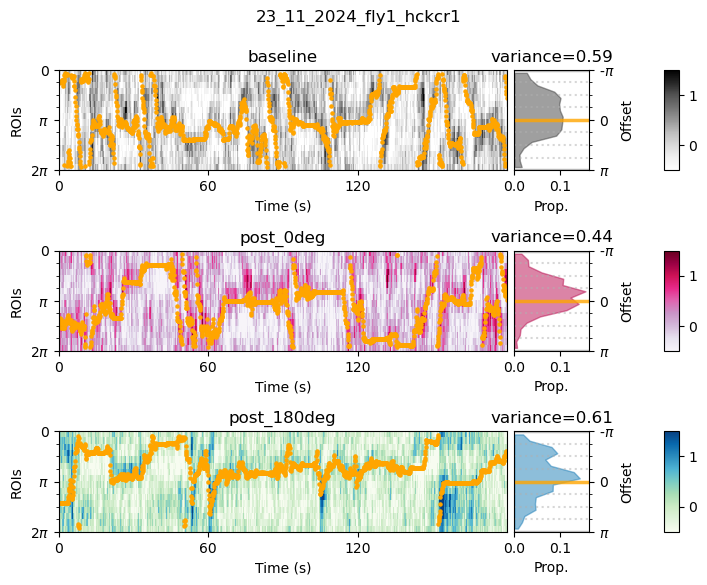

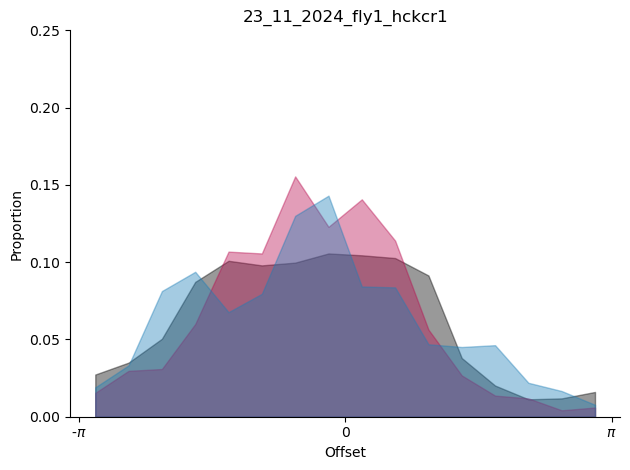

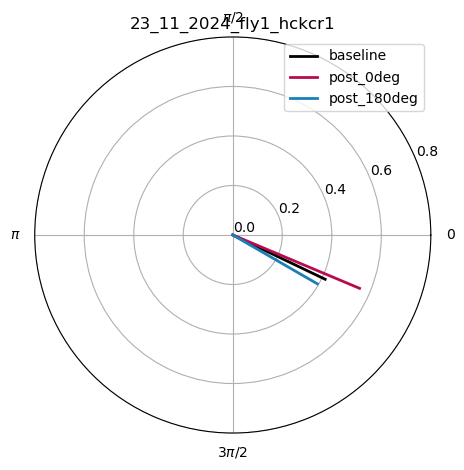

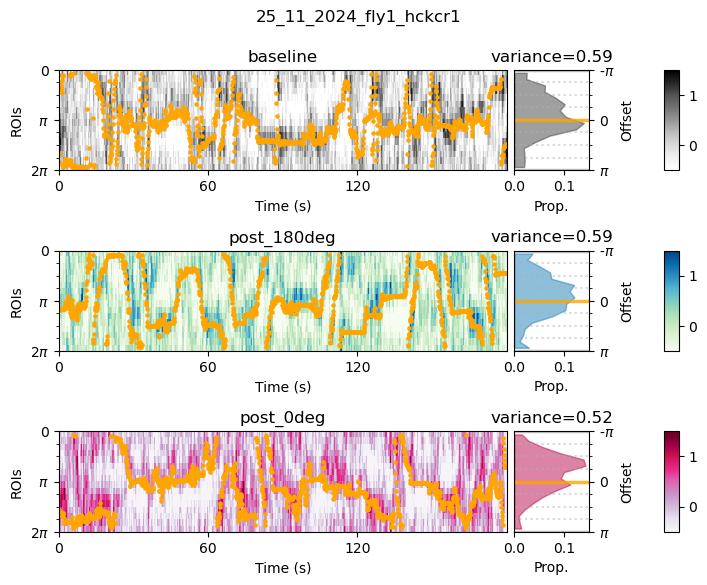

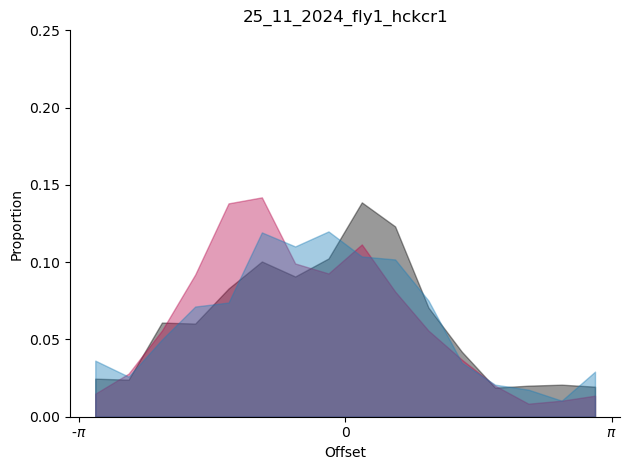

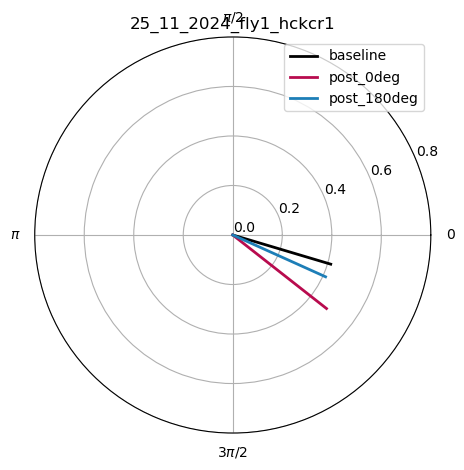

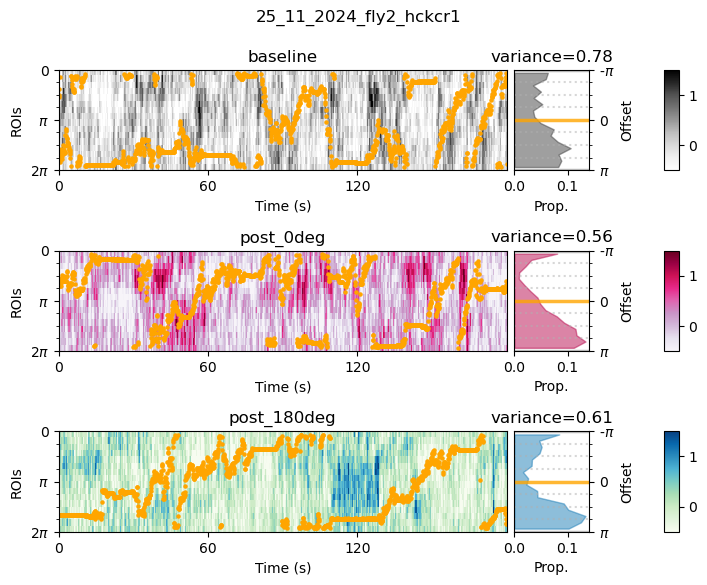

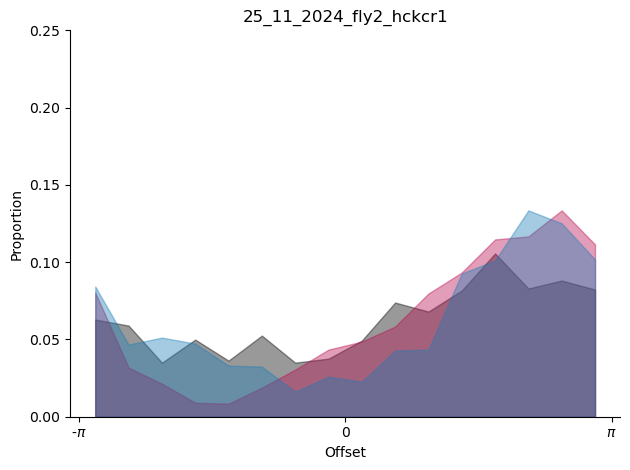

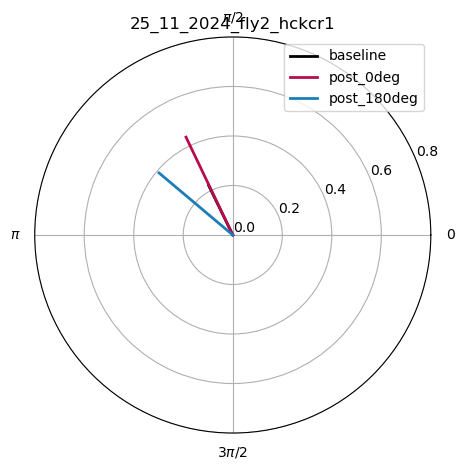

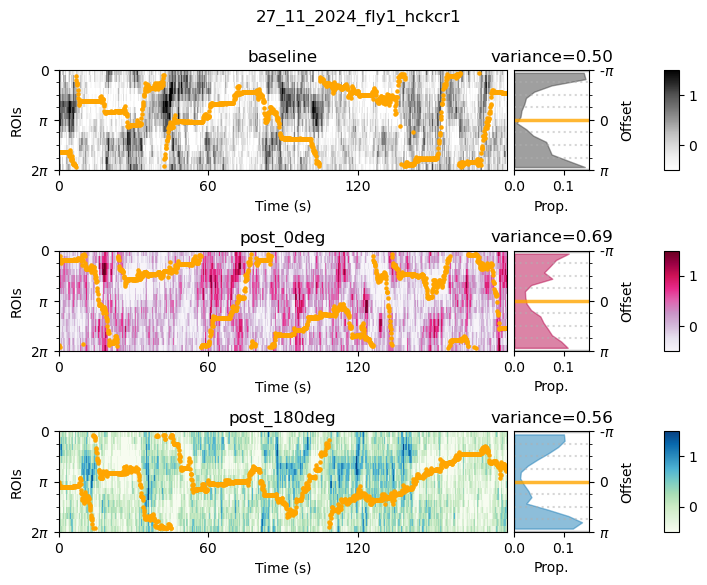

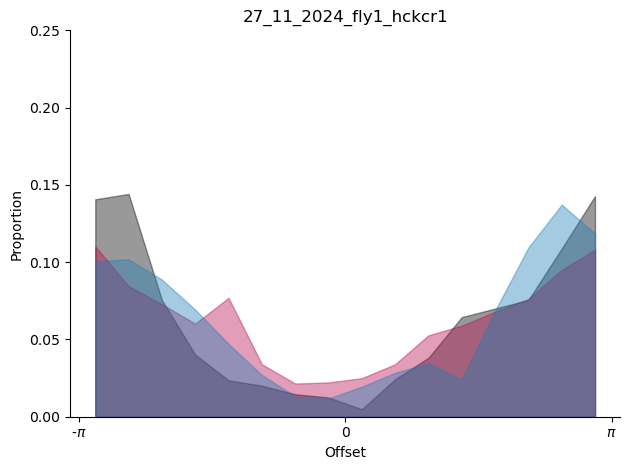

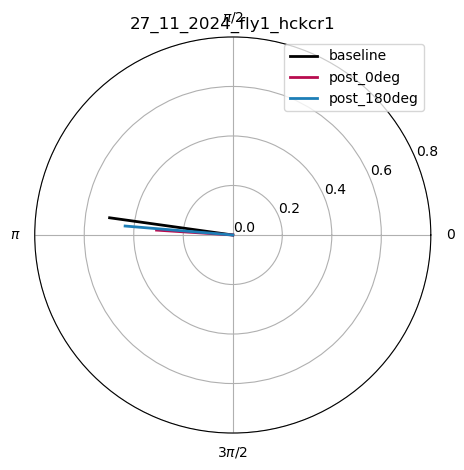

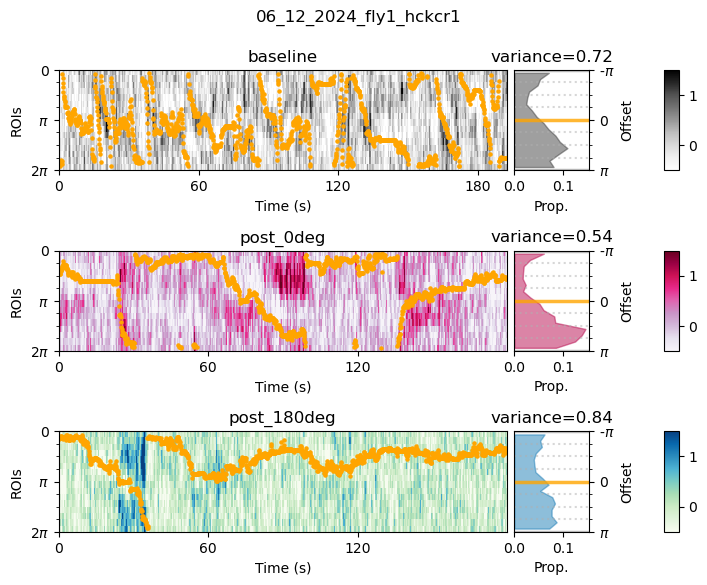

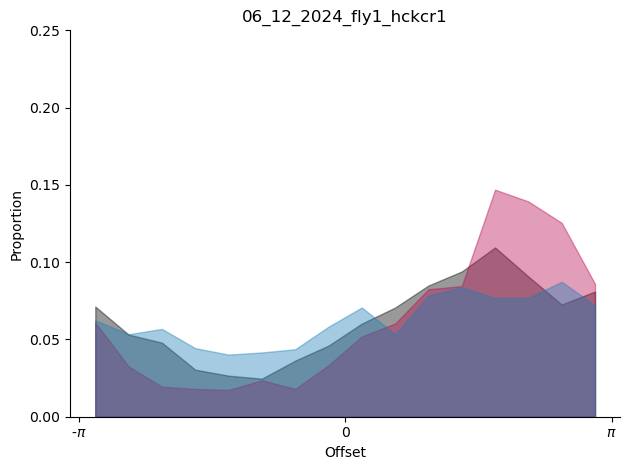

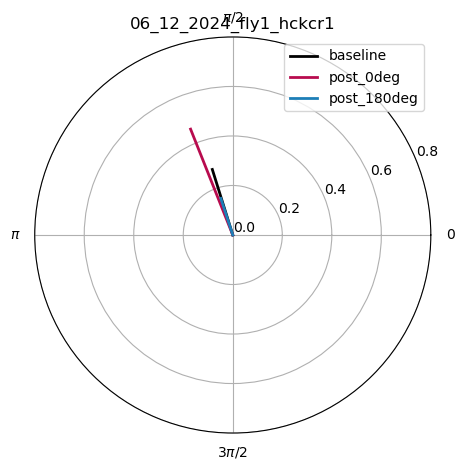

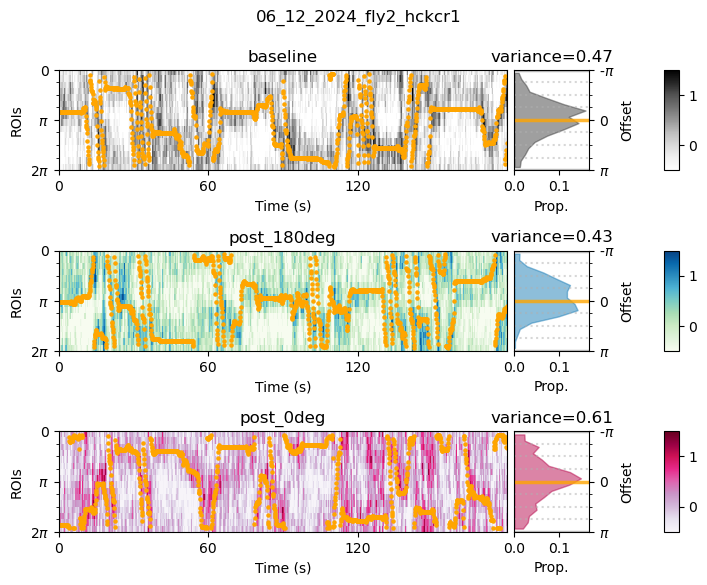

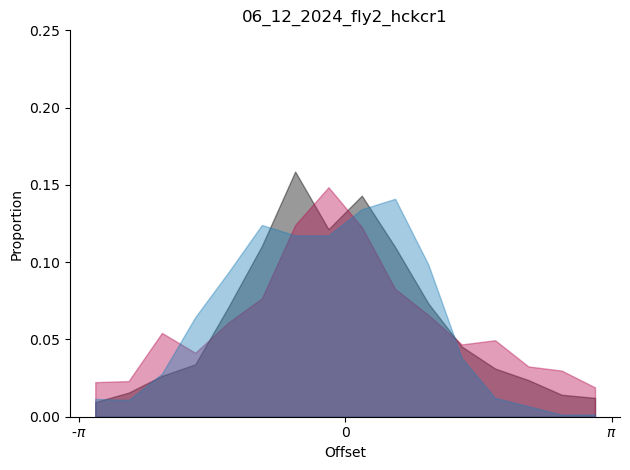

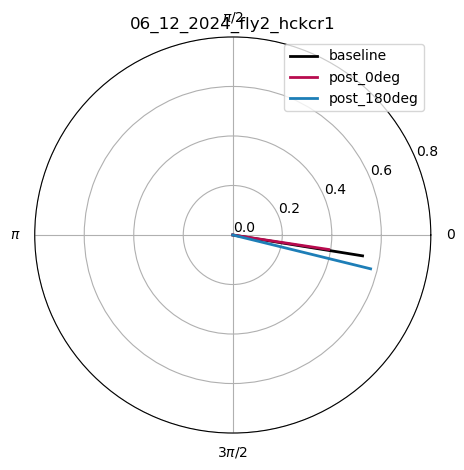

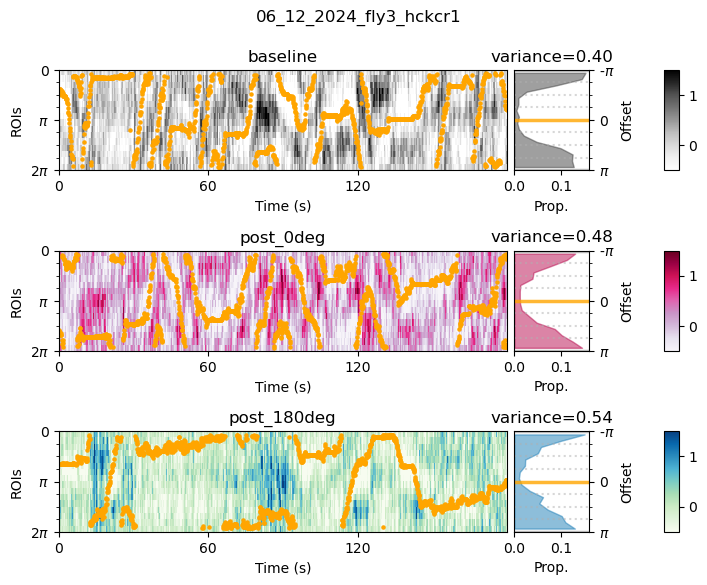

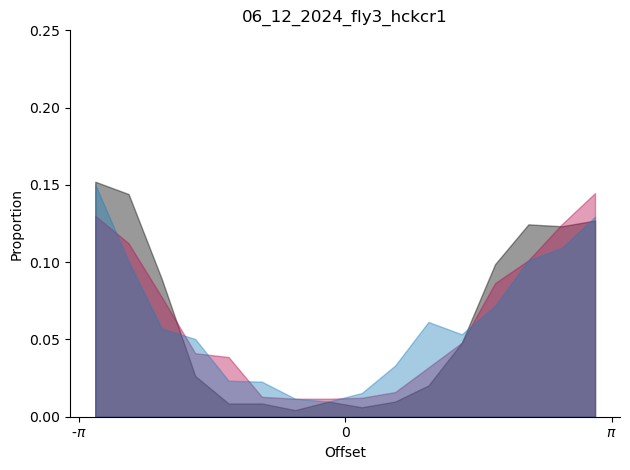

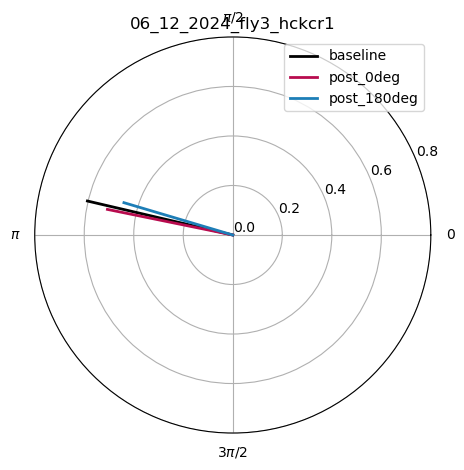

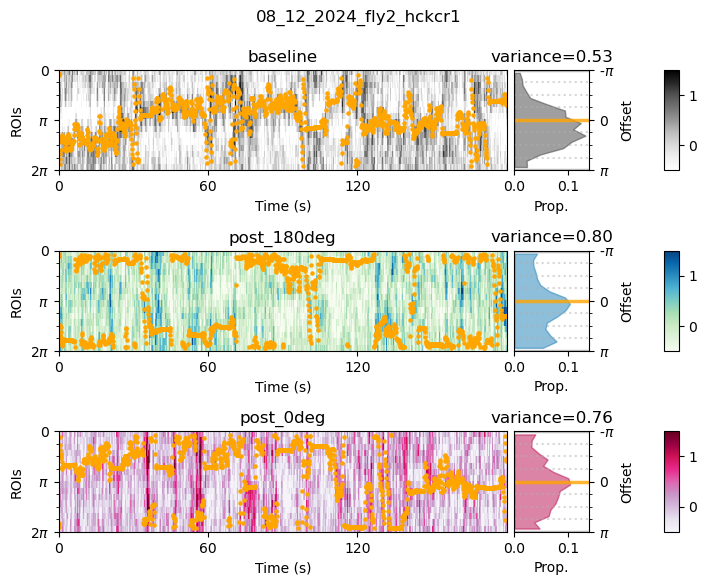

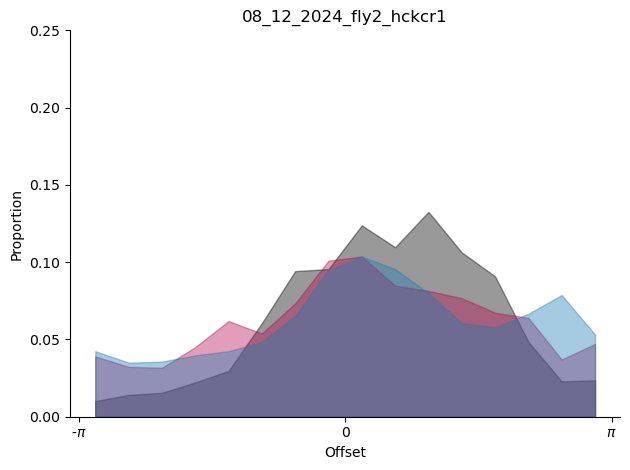

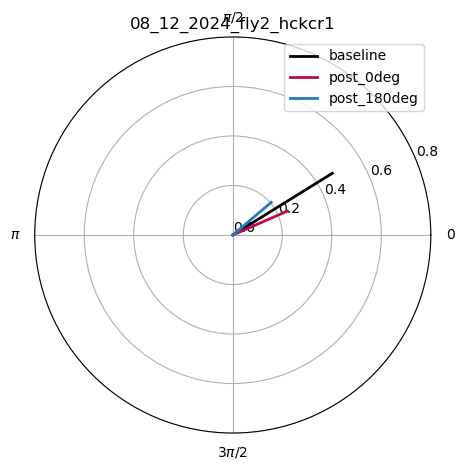

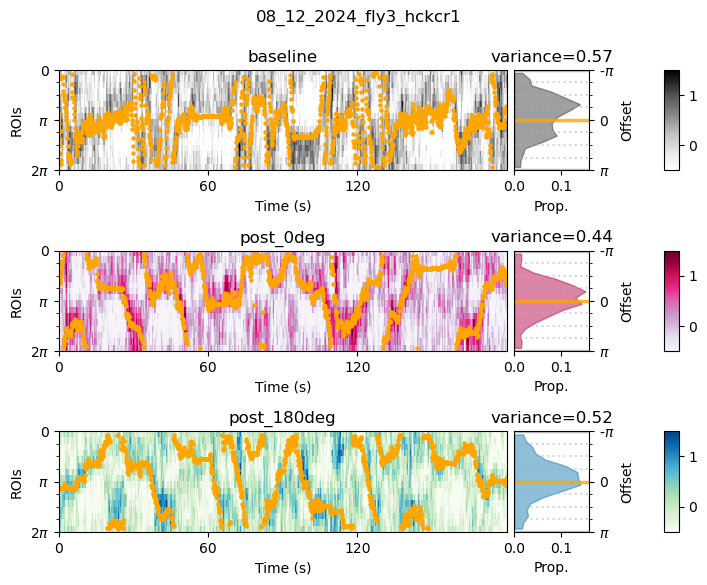

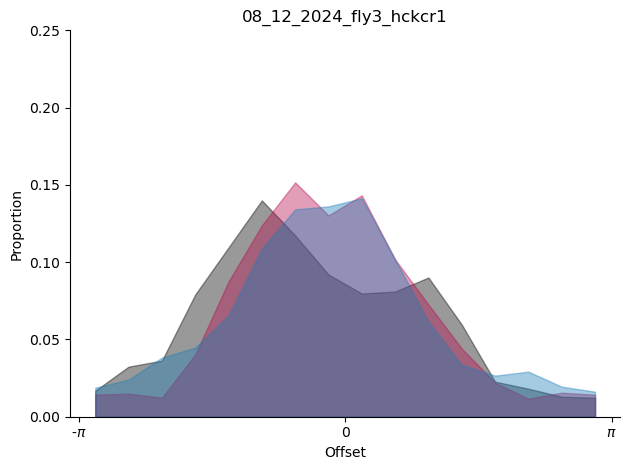

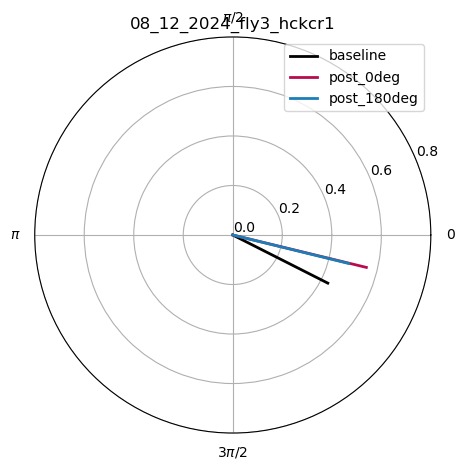

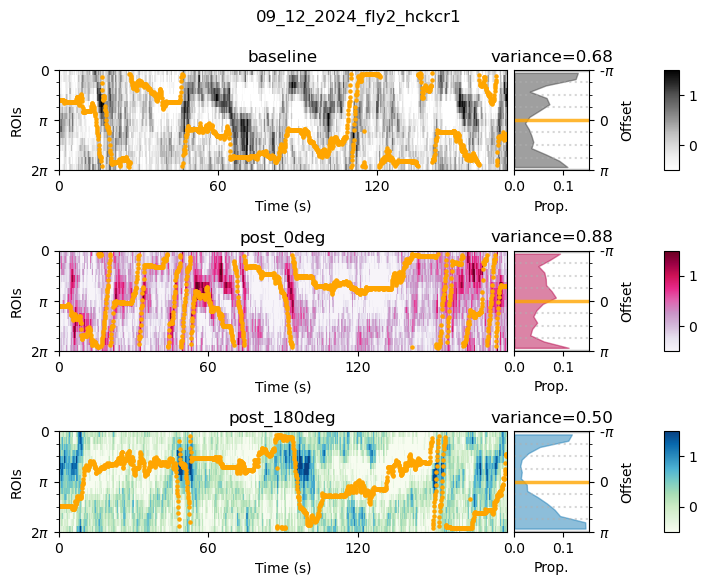

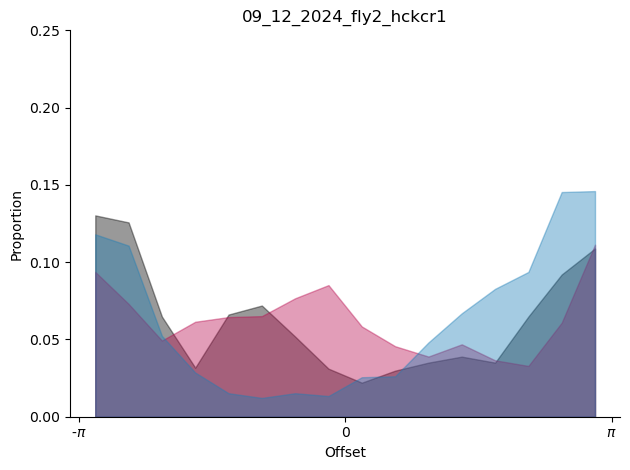

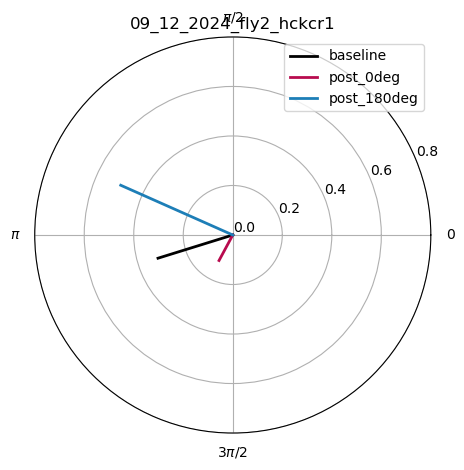

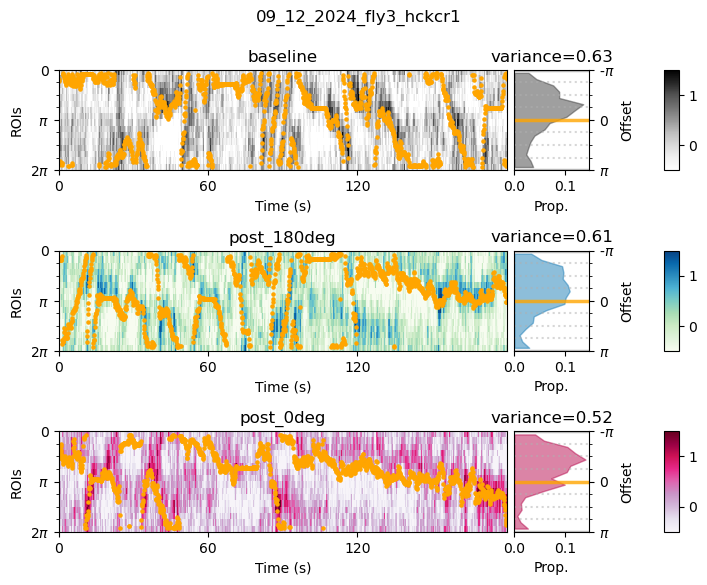

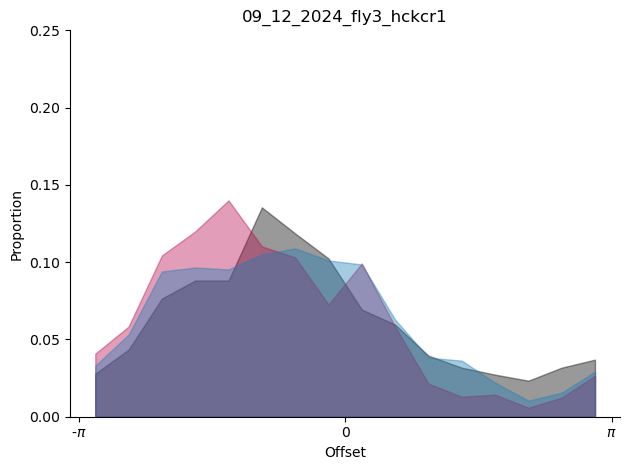

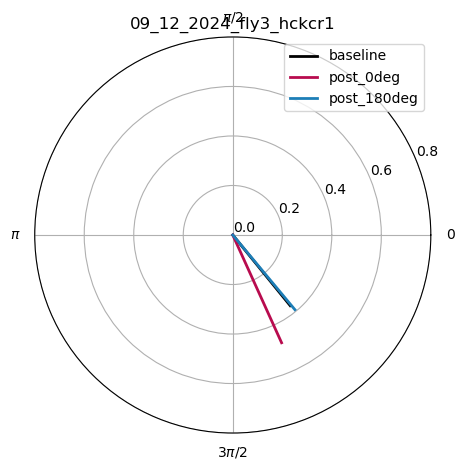

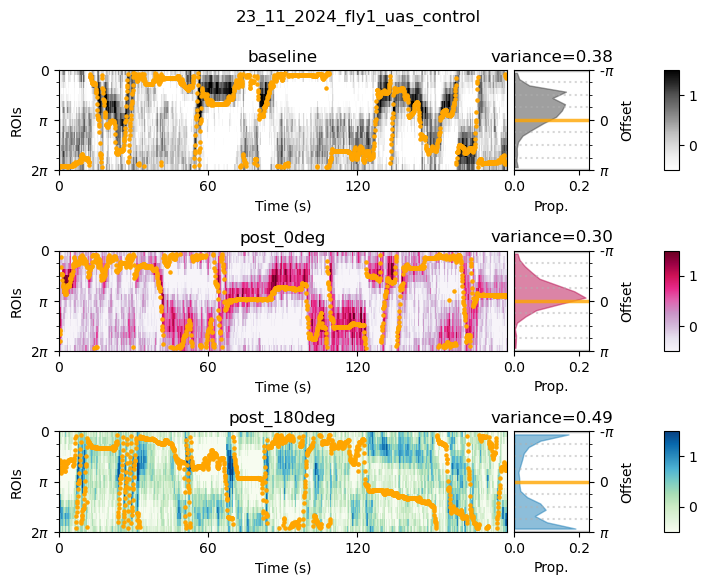

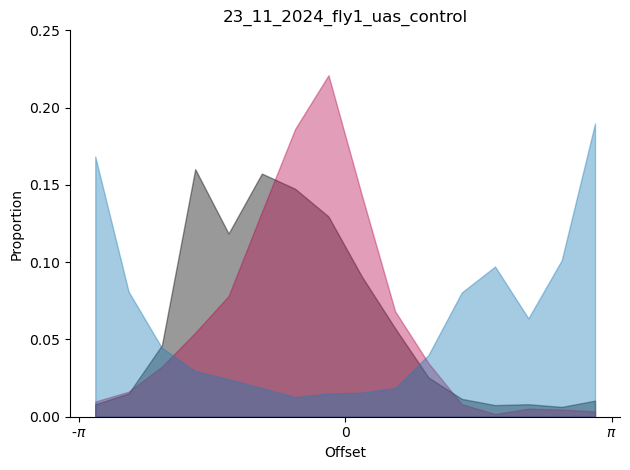

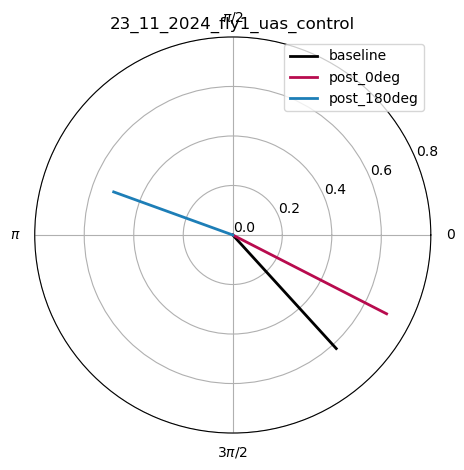

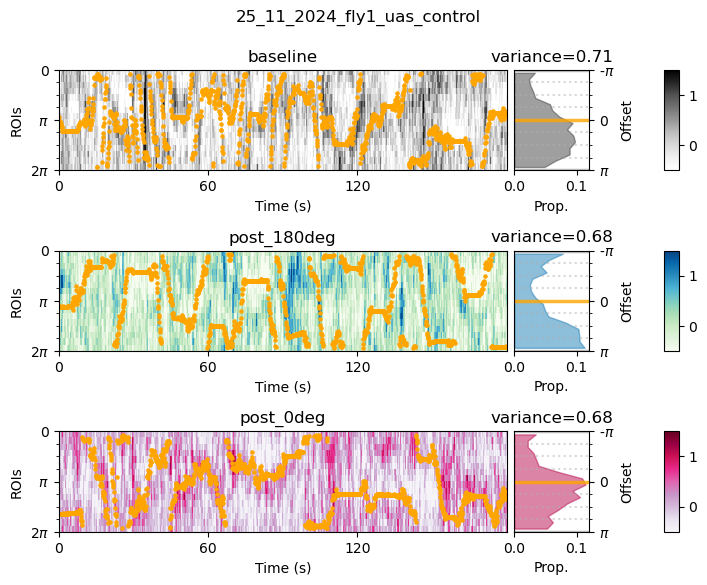

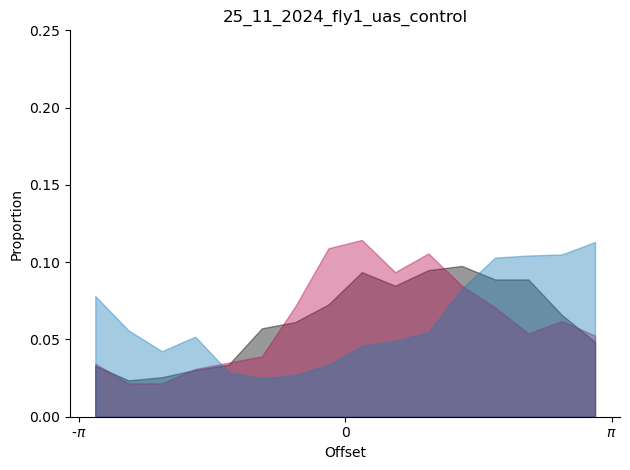

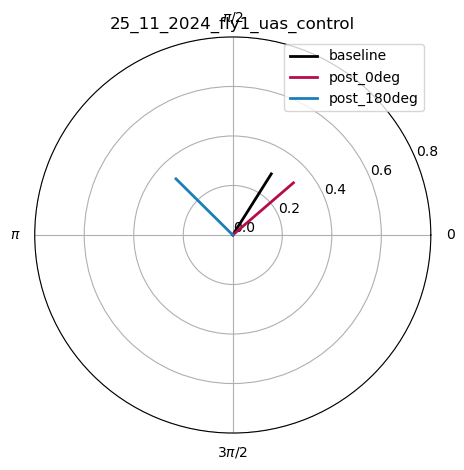

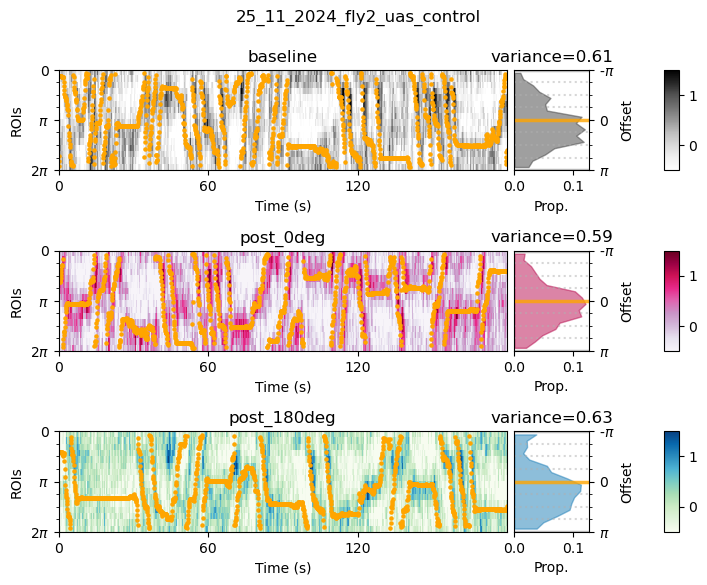

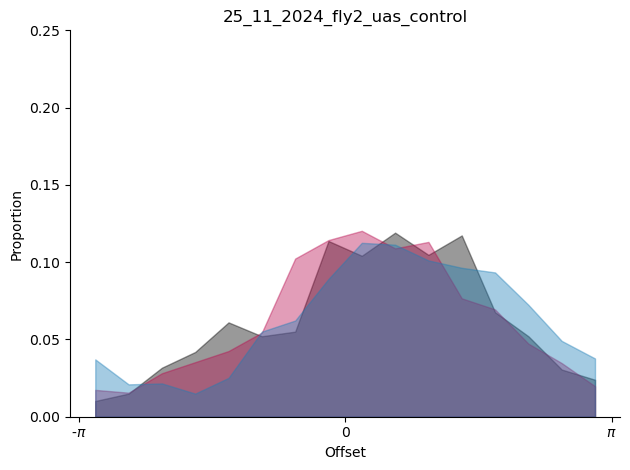

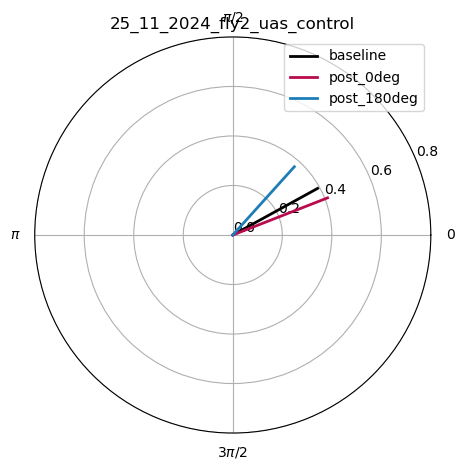

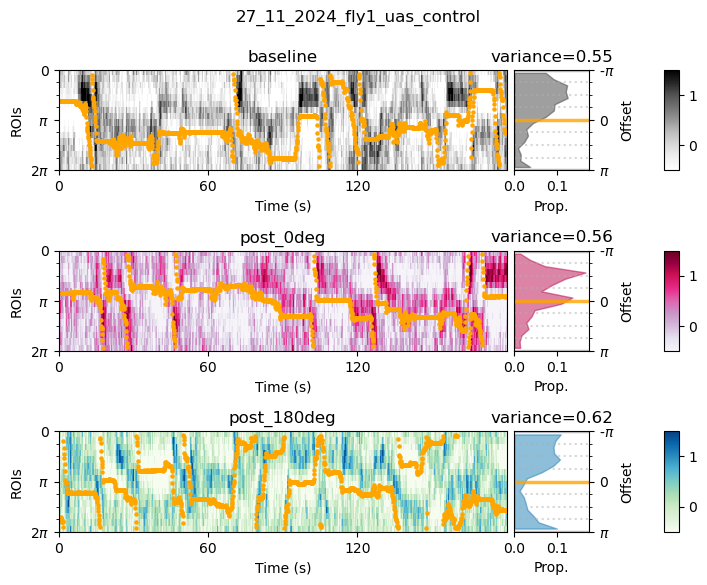

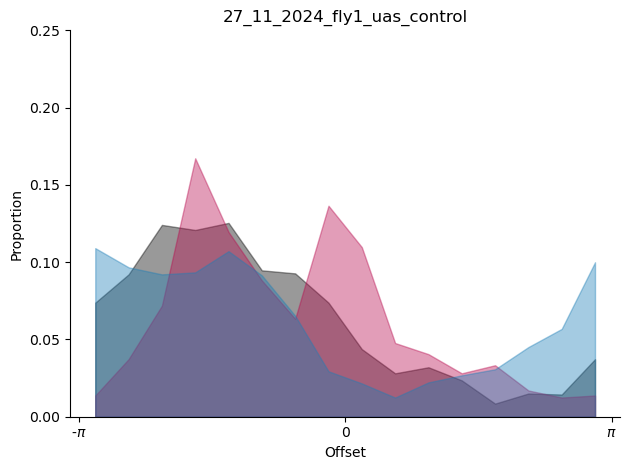

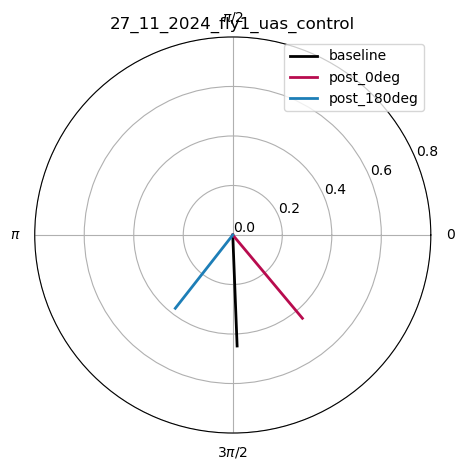

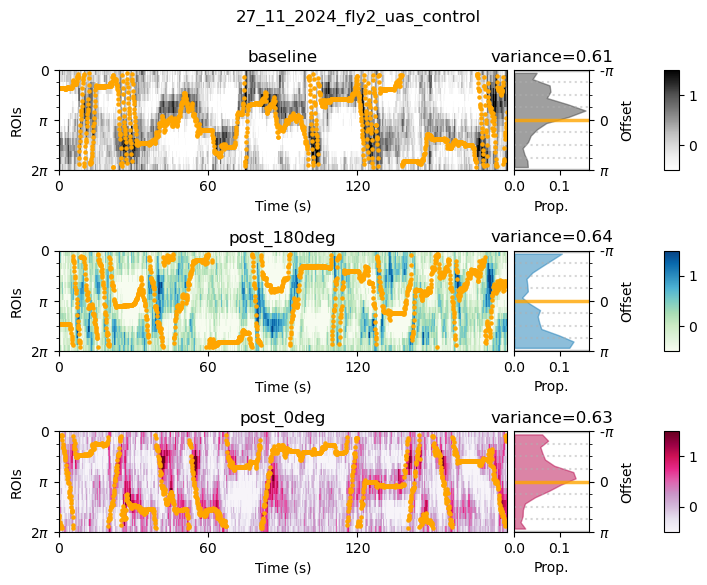

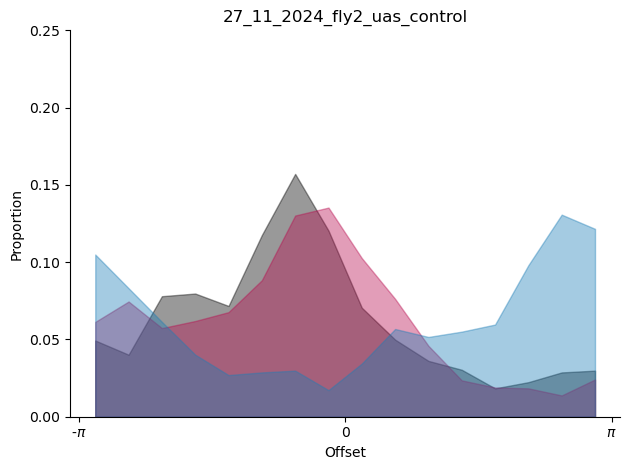

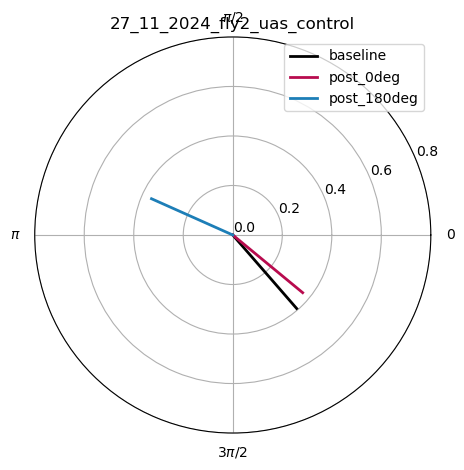

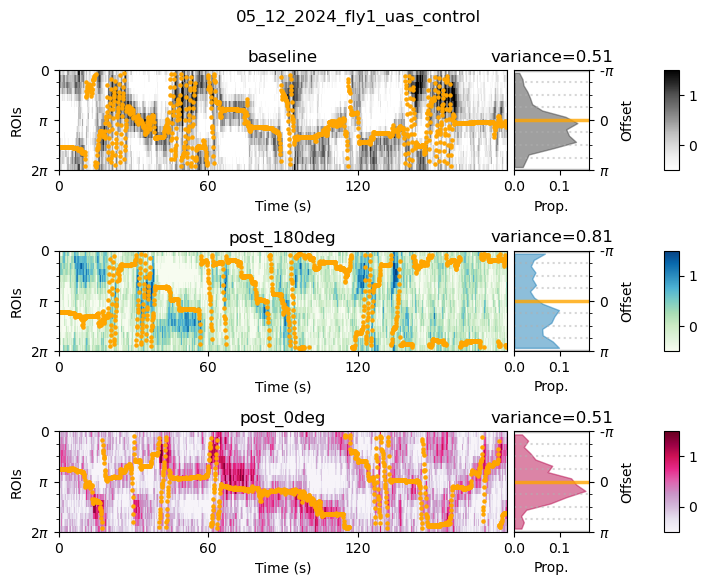

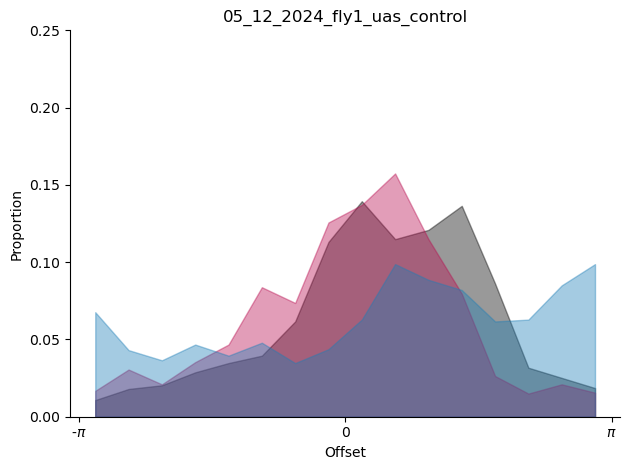

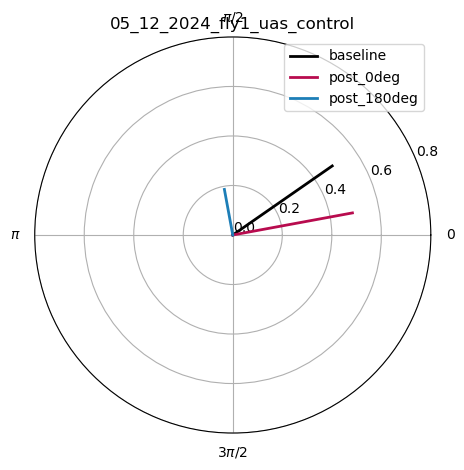

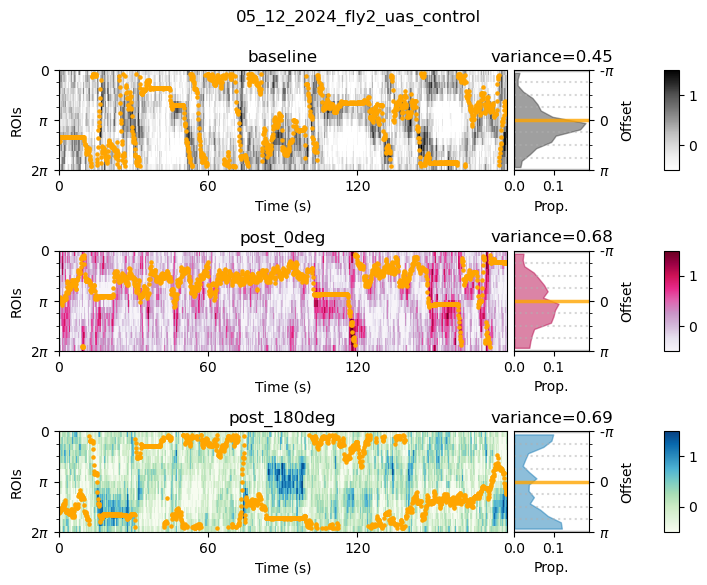

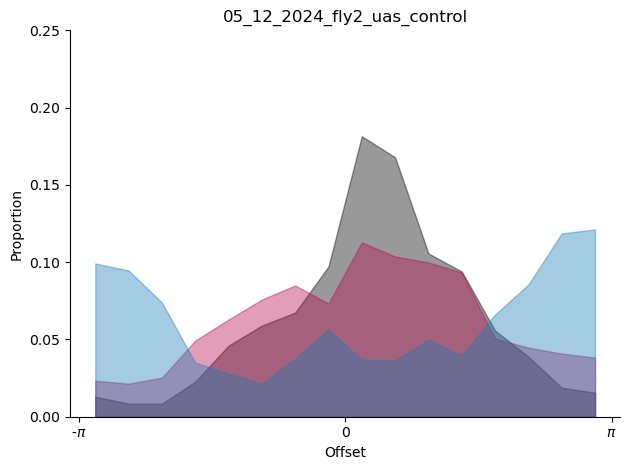

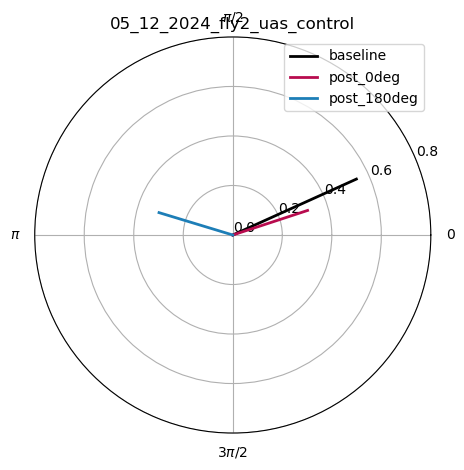

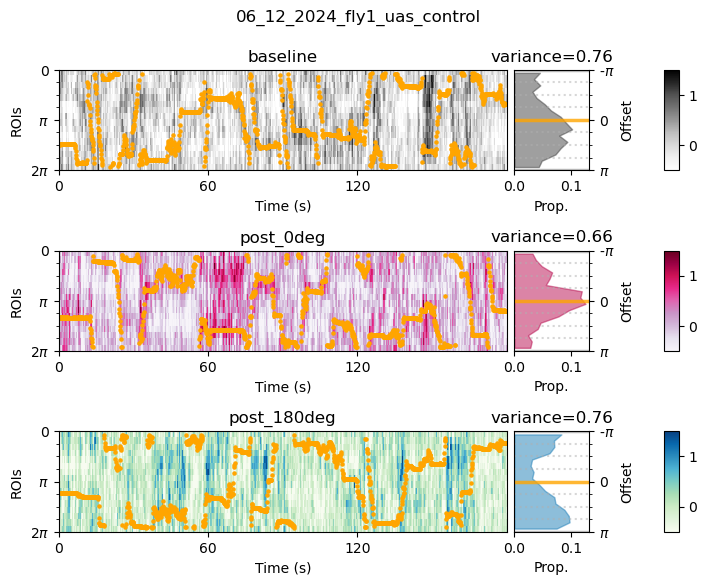

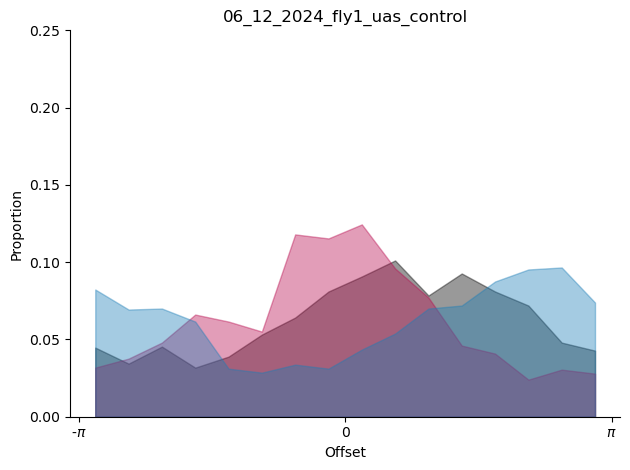

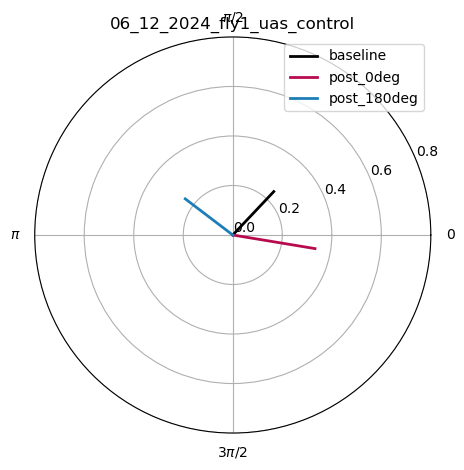

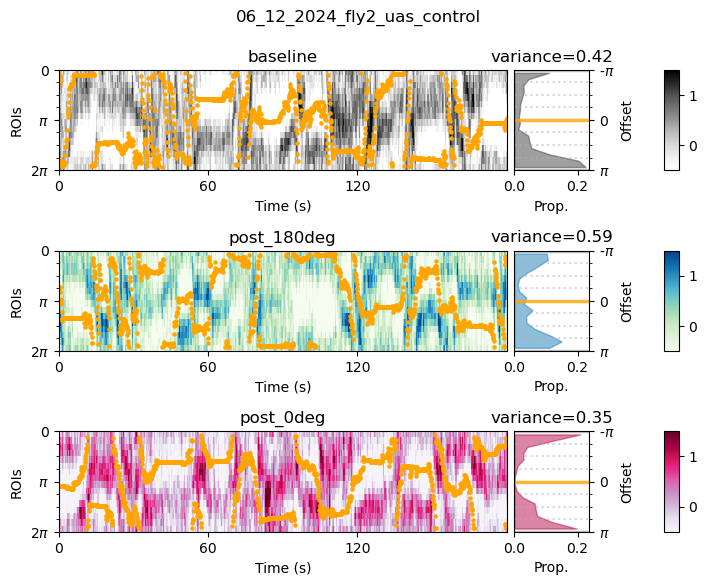

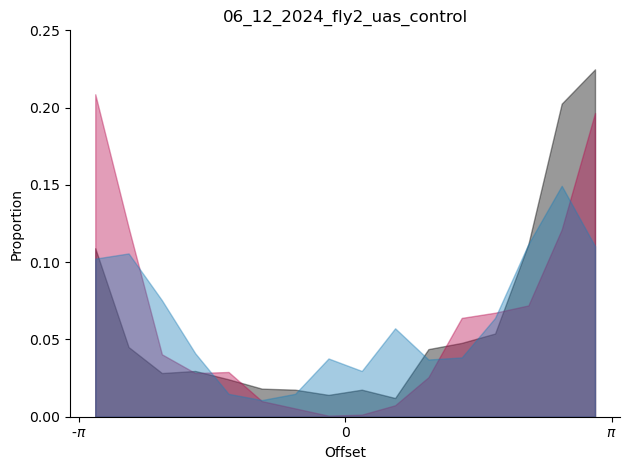

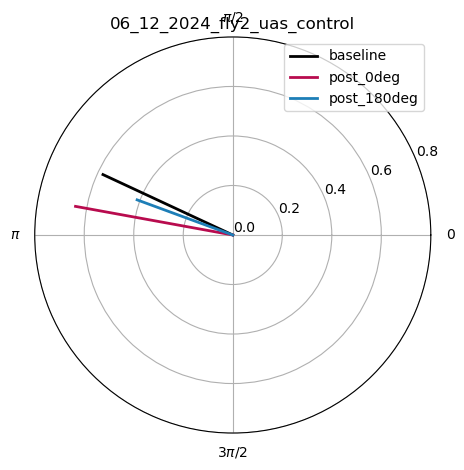

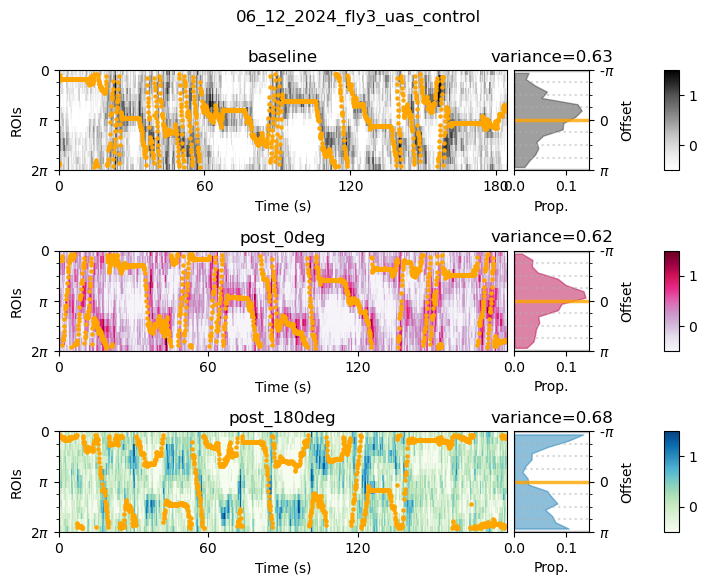

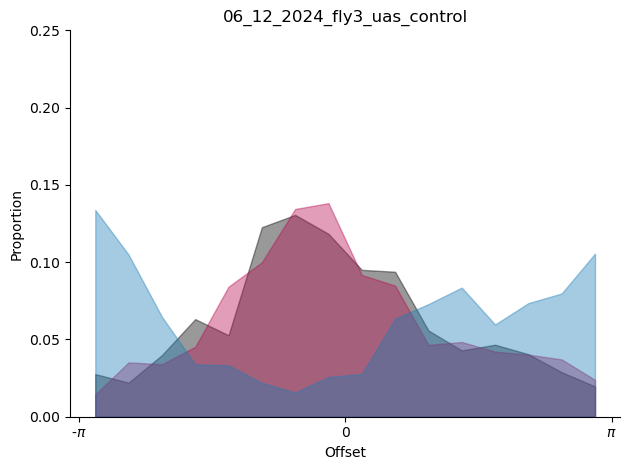

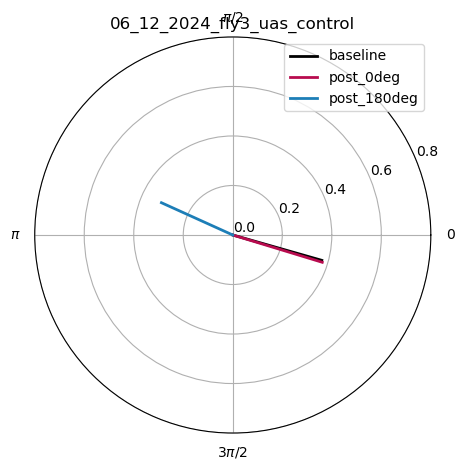

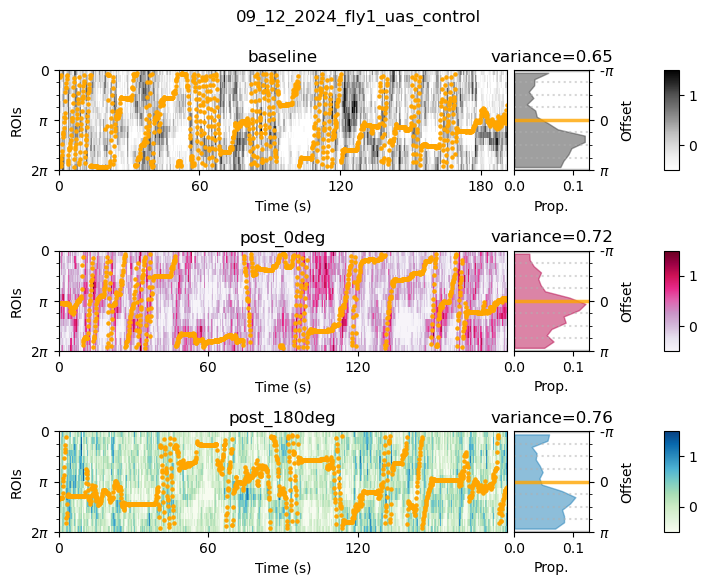

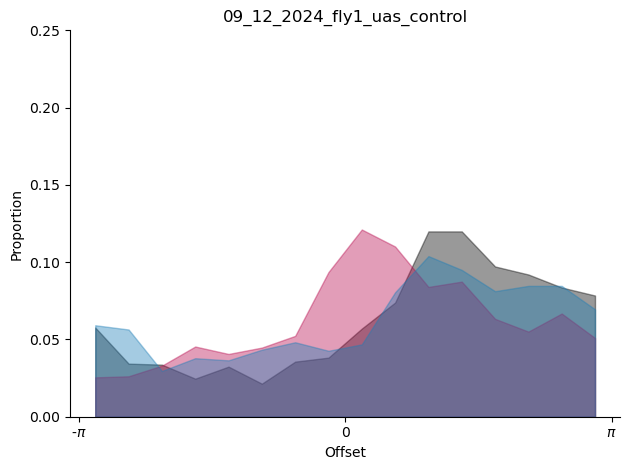

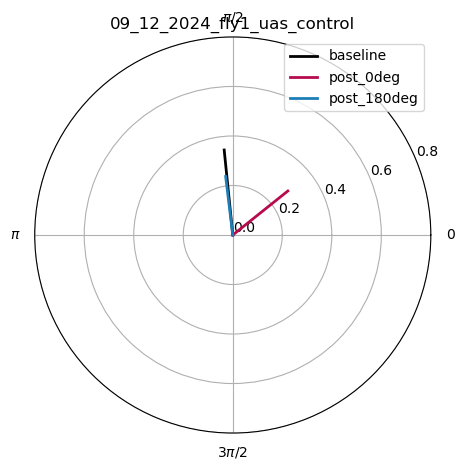

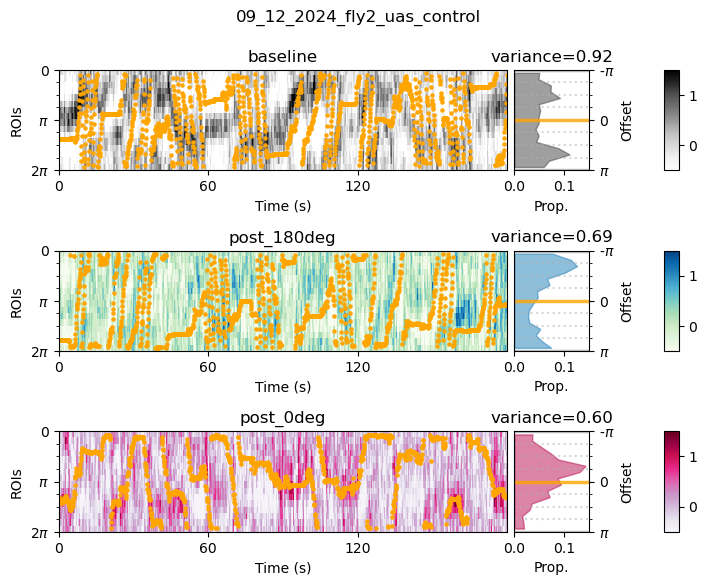

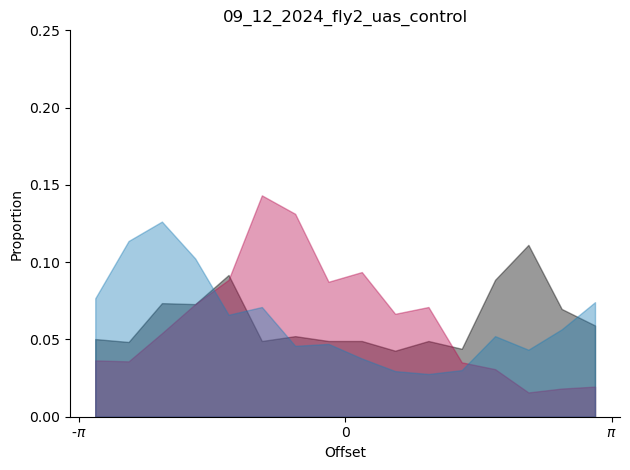

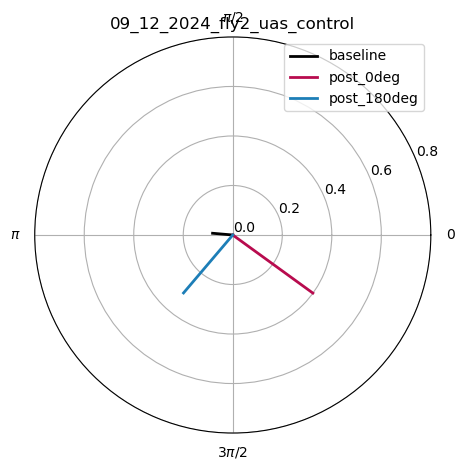

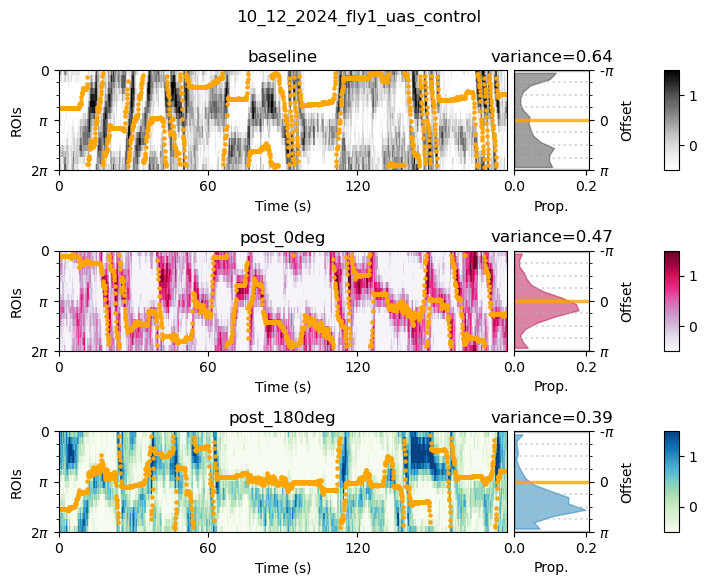

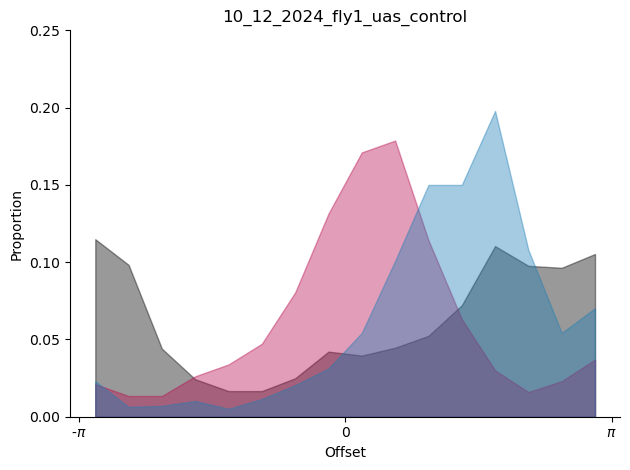

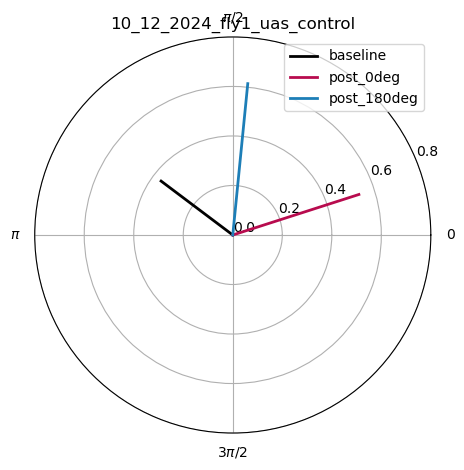

In [ ]:
session_folder = figfolder / "sessions"
session_folder.mkdir(parents=True, exist_ok=True)


for fly in flies:

    baseline = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='baseline')]
    post_0deg = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='post_0deg')]
    post_180deg = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['scan_type']=='post_180deg')]

    if baseline.shape[0]>0 and post_0deg.shape[0]>0 and post_180deg.shape[0]>0:
        sess_inds = (
            int(baseline.iloc[0]['sess'][-3:]), 
            int(post_0deg.iloc[0]['sess'][-3:]), 
            int(post_180deg.iloc[0]['sess'][-3:]), 
        )
        sess_order = np.argsort(sess_inds)
        print(sess_inds,sess_order)
        
    

        ts_dict = {'fly': fly,
                'baseline': nmp.session.GetTS(load_row(baseline.iloc[0])),
                'post_0deg': nmp.session.GetTS(load_row(post_0deg.iloc[0])),
                'post_180deg': nmp.session.GetTS(load_row(post_180deg.iloc[0]))}

        fig_heatmaps, ax_heatmaps = nmp.remapping.plot_sess_heatmaps_w_hist(ts_dict,vmin=-.5, vmax=1.5, sess_order=sess_order)
        (fig_hist, ax_hist), (fig_polar, ax_polar) = nmp.remapping.plot_sess_histograms(ts_dict)

        
        fly_folder = session_folder / fly
        fly_folder.mkdir(parents=True, exist_ok=True)
        
        fig_heatmaps.savefig(fly_folder / "heatmaps.pdf")
        fig_hist.savefig(fly_folder / "offset_hist.pdf")
        fig_polar.savefig(fly_folder / "offset_polar.pdf")